Heart Failures - ML in healthcare - MLP (MULTI LAYER PERCEPTRON)
===

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


# , precision_score, recall_score, auc, roc_curve, roc_auc_score, accuracy_score, classification_report 

In [5]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [6]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [7]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 '0': '{:.0%}',
 '1': '{:.0%}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

# Local Parameters

In [83]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    n_nodes                  = param.Integer(default=20, bounds=(1,100),doc="Number of nodes in hidden layer")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=20 ,bounds=(5,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(True, doc="Whether we want to standardize numerical features")
    stand_embeddings         = param.Boolean(False, doc="Whether we want to standardize embeddings")
    use_lasso                = param.Boolean(False)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
    add_embeddings	         = param.Boolean(False, doc="Whether to add embeddings from categorical variables")
    max_emb_dim							 = param.Integer(50, bounds=(10,100),doc="Maximum embedding dimension")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [9]:
df_heart = pd.read_csv('heart.csv')
df_heart_test = pd.read_csv('test_split.csv')
df_heart_train = pd.read_csv('train_val_split.csv')

In [10]:
df_heart.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


# Features Preprocessing

In [11]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
label_col = 'HeartDisease'

In [12]:
pn.Column(
    pn.Row(base.param.add_embeddings, base.param.add_one_hot_encoded, base.param.stand_features, base.param.stand_embeddings),
    pn.Row(base.param.max_emb_dim, base.param.test_size)
        )

BokehModel(combine_events=True, render_bundle={'docs_json': {'418969ff-2d2e-40e5-ac94-473b136bc814': {'version…

In [13]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [14]:
train_test_data, final_categorical_features, all_features, embeddings_output = lib.pre_process_features(
        df_heart_train,
        num_features=num_features,
        categorical_features=categorical_features,
        category_to_drop=None,
        label_col=label_col,
        add_embeddings=base.add_embeddings,
        add_one_hot_encoded=base.add_one_hot_encoded,
        stand_features=base.stand_features,
        stand_embeddings=base.stand_embeddings,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        replace_pb_values={
            'Cholesterol': {
                'target_to_replace': 0,
                'replacement_method': 'median',
            }
				},
)
X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
X_train_df = train_test_data.dataframes['X_train']

Before: Number of rows with problematic value: (141,)
After: Number of rows with problematic value: (0,)
adding One Hot Encoded
['M' 'F']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


## Working with the class imbalance

In [15]:
# From ... https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/#focal-loss
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights)

In [16]:
class_weights

[2.2150943396226412, 1.8229813664596275]

# Model Building

In [17]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        loss = (self.alpha[targets.long()] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

With Embeddings (initial implementation)

In [18]:
# From https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/
# From https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

class MLP(torch.nn.Module):
	'''
		Multilayer Perceptron.
	'''

	def __init__(self, emb_dims, n_cont_features, lin_layer_sizes,
			  output_size, emb_dropout, lin_layer_dropouts):
		'''
		Parameters
		----------

		emb_dims: List of two element tuples
			This list will contain a two element tuple for each
			categorical feature. The first element of a tuple will
			denote the number of unique values of the categorical
			feature. The second element will denote the embedding
			dimension to be used for that feature.

		n_cont_features: Integer
			The number of continuous features in the data.

		lin_layer_sizes: List of integers.
			The size of each linear layer. The length will be equal
			to the total number
			of linear layers in the network.

		output_size: Integer
			The size of the final output.

		emb_dropout: Float
			The dropout to be used after the embedding layers.

		lin_layer_dropouts: List of floats
			The dropouts to be used after each linear layer.
		'''
		super().__init__()
    # Embedding layers
		self.emb_layers = torch.nn.ModuleList([torch.nn.Embedding(x, y) for x, y in emb_dims])

		n_embs = sum([y for x, y in emb_dims])
		self.n_embs = n_embs
		self.n_cont_features = n_cont_features

		# Linear Layers
		first_lin_layer = torch.nn.Linear(self.n_embs + self.n_cont_features, 
							  lin_layer_sizes[0])

		self.lin_layers =\
			torch.nn.ModuleList([first_lin_layer] +\
					[torch.nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
						for i in range(len(lin_layer_sizes) - 1)])
    
		for lin_layer in self.lin_layers:
			torch.nn.init.kaiming_normal_(lin_layer.weight.data) # TODO(jpinole): check if necessary

		# Output Layer
		self.output_layer = torch.nn.Linear(lin_layer_sizes[-1], output_size)
		torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

		# # Batch Norm Layers
		# self.first_bn_layer = torch.nn.BatchNorm1d(self.n_cont_features)
		# self.bn_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(size)
		# 																for size in lin_layer_sizes])

		# Dropout Layers
		self.emb_dropout_layer = torch.nn.Dropout(emb_dropout)
		self.droput_layers = torch.nn.ModuleList([torch.nn.Dropout(size)
																	for size in lin_layer_dropouts])
		
		# Sigmoid Activation
		self.sigmoid = torch.nn.Sigmoid()


	def forward(self, cont_data, cat_data):

		if self.n_embs != 0:
			x = [emb_layer(cat_data[:, i])
						for i,emb_layer in enumerate(self.emb_layers)]
			x = torch.cat(x, 1)
			x = self.emb_dropout_layer(x)

		if self.n_cont_features != 0:
			# normalized_cont_data = self.first_bn_layer(cont_data)

			if self.n_embs != 0:
				# x = torch.cat([x, normalized_cont_data], 1) 
				x = torch.cat([x, cont_data], 1) 
			else:
				# x = normalized_cont_data
				x = cont_data

		# for lin_layer, dropout_layer, bn_layer in\
		# 		zip(self.lin_layers, self.droput_layers, self.bn_layers):
		for lin_layer, dropout_layer in\
				zip(self.lin_layers, self.droput_layers):
			x = F.relu(lin_layer(x))
			# x = bn_layer(x)
			x = dropout_layer(x)

		x = self.sigmoid(self.output_layer(x))

		return x

With OHE (final implementation)

In [57]:
# From https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/
# From https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

class MLP(torch.nn.Module):
	'''
		Multilayer Perceptron.
	'''

	def __init__(self, emb_dims, n_cont_features, lin_layer_sizes,
			  output_size, emb_dropout, lin_layer_dropouts):
		'''
		Parameters
		----------

		emb_dims: List of two element tuples
			This list will contain a two element tuple for each
			categorical feature. The first element of a tuple will
			denote the number of unique values of the categorical
			feature. The second element will denote the embedding
			dimension to be used for that feature.

		n_cont_features: Integer
			The number of continuous features in the data.

		lin_layer_sizes: List of integers.
			The size of each linear layer. The length will be equal
			to the total number
			of linear layers in the network.

		output_size: Integer
			The size of the final output.

		emb_dropout: Float
			The dropout to be used after the embedding layers.

		lin_layer_dropouts: List of floats
			The dropouts to be used after each linear layer.
		'''
		super().__init__()


		# Linear Layers
		first_lin_layer = torch.nn.Linear(20 ,lin_layer_sizes[0])

		self.lin_layers =\
			torch.nn.ModuleList([first_lin_layer] +\
					[torch.nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
						for i in range(len(lin_layer_sizes) - 1)])
    
		for lin_layer in self.lin_layers:
			torch.nn.init.kaiming_normal_(lin_layer.weight.data) # TODO(jpinole): check if necessary

		# Output Layer
		self.output_layer = torch.nn.Linear(lin_layer_sizes[-1], output_size)
		torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

		# # Batch Norm Layers
		# self.first_bn_layer = torch.nn.BatchNorm1d(self.n_cont_features)
		# self.bn_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(size)
		# 																for size in lin_layer_sizes])

		# Dropout Layers
		self.emb_dropout_layer = torch.nn.Dropout(emb_dropout)
		self.droput_layers = torch.nn.ModuleList([torch.nn.Dropout(size)
																	for size in lin_layer_dropouts])
		
		# Sigmoid Activation
		self.sigmoid = torch.nn.Sigmoid()


	def forward(self, cont_data):
		x = cont_data
		# for lin_layer, dropout_layer, bn_layer in\
		# 		zip(self.lin_layers, self.droput_layers, self.bn_layers):
		for lin_layer, dropout_layer in\
				zip(self.lin_layers, self.droput_layers):
			print(x.shape)
			print(x)
			x = F.relu(lin_layer(x))
			# x = bn_layer(x)
			x = dropout_layer(x)

		x = self.sigmoid(self.output_layer(x))

		return x

# Training

In [58]:
pn.Column(
    pn.Row(base.param.use_lasso, base.param.use_focal_loss),
    pn.Row(base.param.lr_power, base.param.lr_multiple),
    pn.Row(base.param.lambda_power, base.param.lambda_multiple)
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'1df4ff12-490f-4fad-ab1c-b494feb20b3d': {'version…

In [59]:
lr = base.lr_multiple * 10**(-base.lr_power)
print('learning rate is {} multiplied by 10 power {}, which yields {:.8f}'.format(base.lr_multiple, -base.lr_power, lr))
lambda_lasso = base.lambda_multiple * 10**(-base.lambda_power)
print('lambda_lasso is {} multiplied by 10 power {}, which yields {:.6f}'.format(base.lambda_multiple, -base.lambda_power, lambda_lasso))

learning rate is 5 multiplied by 10 power -3, which yields 0.00500000
lambda_lasso is 1 multiplied by 10 power -2, which yields 0.010000


In [67]:
pn.Column(
    pn.Row(base.param.epochs, base.param.iter_array, base.param.iter_printing),
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'052975ba-9533-4fc7-bb19-93a6e63a56e5': {'version…

In [68]:
input_dim = len(num_features + final_categorical_features)
output_dim = 1 # Single binary output
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(
	emb_dims=embeddings_output['emb_dims'],
	n_cont_features=len(num_features),
	lin_layer_sizes=[50,100],
	output_size=1,
	emb_dropout=0.04,
	lin_layer_dropouts=[0.001, 0.01],
    ).to(device)
if base.use_focal_loss:
    criterion = FocalLoss(alpha=class_weights_tensor.long(), gamma=2)
else:
    criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
iter_printing_effective = int(base.epochs/base.iter_printing)
print('iter_printing_effective is {}'.format(iter_printing_effective))
# torch.manual_seed(0) # keep things reproducible

iter_printing_effective is 399


In [69]:
from torchsummary import summary

In [70]:
summary(model, input_size = (587,20))

torch.Size([2, 587, 20])
tensor([[[0.5611, 0.4171, 0.3245,  ..., 0.6496, 0.6145, 0.1618],
         [0.4441, 0.6826, 0.0754,  ..., 0.9960, 0.9024, 0.1008],
         [0.3533, 0.3393, 0.0234,  ..., 0.6408, 0.2119, 0.8835],
         ...,
         [0.6058, 0.2143, 0.4457,  ..., 0.4118, 0.0802, 0.0045],
         [0.1842, 0.9241, 0.4120,  ..., 0.3572, 0.2239, 0.4676],
         [0.1446, 0.2495, 0.7369,  ..., 0.0871, 0.3731, 0.9128]],

        [[0.3150, 0.7202, 0.8920,  ..., 0.4861, 0.6467, 0.3675],
         [0.1487, 0.4822, 0.3511,  ..., 0.8314, 0.1940, 0.6158],
         [0.3693, 0.8552, 0.8484,  ..., 0.7296, 0.7877, 0.6527],
         ...,
         [0.8790, 0.8405, 0.0175,  ..., 0.5117, 0.4685, 0.8692],
         [0.0764, 0.0684, 0.2030,  ..., 0.3641, 0.0675, 0.4317],
         [0.1922, 0.6281, 0.5174,  ..., 0.7932, 0.0766, 0.8363]]])
torch.Size([2, 587, 50])
tensor([[[0.0000, 0.3281, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.6924, 0.3964, 0.0000,  ..., 0.0000, 0.0000, 0.2707],
        

In [71]:
X_train['all'].shape

torch.Size([587, 20])

In [72]:
losses = []
losses_test = []
Iterations = []
iter = 0
model.train()
for epoch in tqdm(range(int(base.epochs)),desc='Training Epochs'):
		x = X_train
		labels = y_train
		optimizer.zero_grad() # Setting our stored gradients equal to zero
		# outputs = model(X_train['num'], X_train['cat'])  # Perform forward pass
		outputs = model(X_train['all'])  # Perform forward pass
		loss = criterion(torch.squeeze(outputs), labels) # Compute loss
		loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

		# Compute L1 loss component
		# if base.use_lasso:
		#     loss = add_l1_loss(model, loss, lambda_lasso=lambda_lasso)

		optimizer.step() # Updates weights and biases with the optimizer (SGD)
		
		iter+=1
		if iter%base.iter_array==0:
				with torch.no_grad():
						# Calculating the loss and accuracy for the test dataset
						correct_test = 0
						total_test = 0
						outputs_test = torch.squeeze(model(X_test['all']))
						loss_test = criterion(outputs_test, y_test)
						# loss_test = add_l1_loss(model, loss_test, lambda_lasso=lambda_lasso)
						
						predicted_test = outputs_test.round().detach().numpy()
						total_test += y_test.size(0)
						correct_test += np.sum(predicted_test == y_test.detach().numpy())
						accuracy_test = 100 * correct_test/total_test
						losses_test.append(loss_test.item())
						
						
						# Calculating the loss and accuracy for the train dataset
						total = 0
						correct = 0
						total += y_train.size(0)
						correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
						accuracy = 100 * correct/total
						losses.append(loss.item())
						Iterations.append(iter)

						if iter%iter_printing_effective==0:
								print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
								print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:   0%|          | 8/1999 [00:00<00:39, 50.11it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1450, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0673, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2322, 0.7249, 0.0632,  ..., 0.2927, 0.0000, 0.0523],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1585, 0.0000, 0.0000],
        [0.5759, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4231],
        [0.8651, 0.2650, 0.1898,  ..., 0.0000, 0.0000, 1.0388]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:   1%|          | 19/1999 [00:00<00:46, 42.98it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1521, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0697, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2357, 0.7252, 0.0632,  ..., 0.2933, 0.0000, 0.0528],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1594, 0.0000, 0.0000],
        [0.5827, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4242],
        [0.8674, 0.2642, 0.1899,  ..., 0.0000, 0.0000, 1.0393]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:   2%|▏         | 33/1999 [00:00<00:35, 55.64it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0342, 0.0000, 0.0000],
        [0.0000, 0.5957, 0.0784,  ..., 0.1278, 0.0000, 0.0000],
        [0.7426, 0.0000, 0.1188,  ..., 0.0000, 0.0000, 0.4550],
        ...,
        [0.7177, 0.3298, 0.1093,  ..., 0.0469, 0.0000, 0.7674],
        [0.3565, 0.0000, 0.0000,  ..., 0.0142, 0.0000, 0.7179],
        [0.7218, 0.0000, 0.1009,  ..., 0.2820, 0.0000, 0.4673]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:   2%|▏         | 40/1999 [00:00<00:33, 58.15it/s]

torch.Size([587, 50])
tensor([[0.1589, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0701, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2351, 0.7208, 0.0643,  ..., 0.2915, 0.0000, 0.0533],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1583, 0.0000, 0.0000],
        [0.5893, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4258],
        [0.8644, 0.2577, 0.1911,  ..., 0.0000, 0.0000, 1.0397]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1591, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0701, 0.0000,  ..., 0.00

Training Epochs:   3%|▎         | 60/1999 [00:00<00:24, 80.00it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1611, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0698, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2340, 0.7183, 0.0648,  ..., 0.2903, 0.0000, 0.0535],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1575, 0.0000, 0.0000],
        [0.5914, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4264],
        [0.8620, 0.2542, 0.1917,  ..., 0.0000, 0.0000, 1.0399]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:   3%|▎         | 69/1999 [00:01<00:23, 81.54it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1639, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0693, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2326, 0.7151, 0.0654,  ..., 0.2888, 0.0000, 0.0538],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1565, 0.0000, 0.0000],
        [0.5941, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4271],
        [0.8590, 0.2497, 0.1924,  ..., 0.0000, 0.0000, 1.0403]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:   4%|▍         | 85/1999 [00:01<00:32, 59.52it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1648, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0692, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2322, 0.7142, 0.0655,  ..., 0.2883, 0.0000, 0.0539],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.0000, 0.0000],
        [0.5950, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4272],
        [0.8580, 0.2483, 0.1927,  ..., 0.0000, 0.0000, 1.0404]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:   5%|▍         | 92/1999 [00:01<00:32, 59.10it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1662, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0690, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2318, 0.7128, 0.0657,  ..., 0.2876, 0.0000, 0.0540],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1558, 0.0000, 0.0000],
        [0.5963, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4274],
        [0.8567, 0.2463, 0.1929,  ..., 0.0000, 0.0000, 1.0405]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:   5%|▌         | 105/1999 [00:01<00:36, 51.20it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1670, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0689, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2316, 0.7120, 0.0658,  ..., 0.2873, 0.0000, 0.0540],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.5970, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4275],
        [0.8560, 0.0000, 0.1931,  ..., 0.0000, 0.0000, 1.0406]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:   6%|▌         | 122/1999 [00:02<00:29, 62.98it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1681, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0688, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2313, 0.7110, 0.0659,  ..., 0.2868, 0.0000, 0.0541],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1553, 0.0000, 0.0000],
        [0.5980, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4275],
        [0.8551, 0.2437, 0.1933,  ..., 0.0000, 0.0000, 1.0407]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:   7%|▋         | 140/1999 [00:02<00:26, 71.17it/s]

tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0254, 0.0000, 0.0000],
        [0.0000, 0.5791, 0.0805,  ..., 0.1205, 0.0000, 0.0000],
        [0.7420, 0.0000, 0.1213,  ..., 0.0000, 0.0000, 0.4566],
        ...,
        [0.7048, 0.3093, 0.1126,  ..., 0.0392, 0.0000, 0.7687],
        [0.3506, 0.0000, 0.0000,  ..., 0.0091, 0.0000, 0.7195],
        [0.7265, 0.0000, 0.1033,  ..., 0.2802, 0.0000, 0.4693]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,

Training Epochs:   8%|▊         | 152/1999 [00:02<00:22, 81.72it/s]

torch.Size([587, 50])
tensor([[0.1704, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0688, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2311, 0.7090, 0.0660,  ..., 0.2859, 0.0000, 0.0542],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1548, 0.0000, 0.0000],
        [0.6001, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4276],
        [0.8533, 0.2405, 0.1936,  ..., 0.0000, 0.0000, 1.0409]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1705, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0688, 0.0000,  ..., 0.00

Training Epochs:   8%|▊         | 161/1999 [00:02<00:28, 65.44it/s]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0240, 0.0000, 0.0000],
        [0.0000, 0.5764, 0.0804,  ..., 0.1193, 0.0000, 0.0000],
        [0.7421, 0.0000, 0.1216,  ..., 0.0000, 0.0000, 0.4567],
        ...,
        [0.7030, 0.3061, 0.1128,  ..., 0.0381, 0.0000, 0.7689],
        [0.3500, 0.0000, 0.0000,  ..., 0.0085, 0.0000, 0.7196],
        [0.7276, 0.0000, 0.1035,  ..., 0.2802, 0.0000, 0.4694]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1716, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0689, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2311, 0.7081, 0.0659,

Training Epochs:   8%|▊         | 169/1999 [00:02<00:36, 49.98it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1718, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0689, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2311, 0.7079, 0.0659,  ..., 0.2854, 0.0000, 0.0542],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1547, 0.0000, 0.0000],
        [0.6014, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4275],
        [0.8522, 0.2387, 0.1937,  ..., 0.0000, 0.0000, 1.0410]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
 

Training Epochs:   9%|▉         | 180/1999 [00:02<00:30, 60.27it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1724, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0689, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2312, 0.7075, 0.0659,  ..., 0.2852, 0.0000, 0.0542],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1546, 0.0000, 0.0000],
        [0.6019, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4275],
        [0.8518, 0.2380, 0.1938,  ..., 0.0000, 0.0000, 1.0410]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
 

Training Epochs:  10%|▉         | 195/1999 [00:03<00:34, 52.45it/s]

torch.Size([587, 50])
tensor([[0.1731, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0689, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2313, 0.7070, 0.0658,  ..., 0.2850, 0.0000, 0.0542],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6025, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4275],
        [0.8515, 0.2372, 0.1938,  ..., 0.0000, 0.0000, 1.0411]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1731, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0690, 0.0000,  ..., 0.00

Training Epochs:  10%|█         | 203/1999 [00:03<00:33, 54.02it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1736, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0690, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2314, 0.7067, 0.0658,  ..., 0.2848, 0.0000, 0.0542],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6029, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4275],
        [0.8513, 0.2367, 0.1938,  ..., 0.0000, 0.0000, 1.0411]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  11%|█         | 217/1999 [00:03<00:30, 57.70it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1742, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0691, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2317, 0.7064, 0.0656,  ..., 0.2847, 0.0000, 0.0543],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6034, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4276],
        [0.8510, 0.2360, 0.1938,  ..., 0.0000, 0.0000, 1.0413]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  11%|█         | 224/1999 [00:03<00:34, 51.01it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1747, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0692, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2318, 0.7061, 0.0655,  ..., 0.2845, 0.0000, 0.0543],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4276],
        [0.8508, 0.2355, 0.1938,  ..., 0.0000, 0.0000, 1.0413]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  12%|█▏        | 238/1999 [00:04<00:32, 53.68it/s]

tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0221, 0.0000, 0.0000],
        [0.0000, 0.5728, 0.0800,  ..., 0.0000, 0.0000, 0.0000],
        [0.7429, 0.0000, 0.1217,  ..., 0.0000, 0.0000, 0.4570],
        ...,
        [0.7011, 0.3018, 0.1129,  ..., 0.0367, 0.0000, 0.7694],
        [0.3499, 0.0000, 0.0000,  ..., 0.0081, 0.0000, 0.7200],
        [0.7299, 0.0000, 0.1036,  ..., 0.2804, 0.0000, 0.4695]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,

Training Epochs:  12%|█▏        | 247/1999 [00:04<00:28, 61.99it/s]

torch.Size([587, 50])
tensor([[0.1757, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0696, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2323, 0.7057, 0.0653,  ..., 0.2842, 0.0000, 0.0544],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6047, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4276],
        [0.8504, 0.2346, 0.1938,  ..., 0.0000, 0.0000, 1.0416]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1757, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0696, 0.0000,  ..., 0.00

Training Epochs:  13%|█▎        | 254/1999 [00:04<00:33, 52.78it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1761, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0697, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2325, 0.7055, 0.0651,  ..., 0.2841, 0.0000, 0.0545],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1544, 0.0000, 0.0000],
        [0.6050, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4278],
        [0.8503, 0.2341, 0.1937,  ..., 0.0000, 0.0000, 1.0417]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  13%|█▎        | 267/1999 [00:04<00:36, 46.87it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0214, 0.0000, 0.0000],
        [0.0000, 0.5718, 0.0796,  ..., 0.1170, 0.0000, 0.0000],
        [0.7433, 0.0000, 0.1217,  ..., 0.0000, 0.0000, 0.4573],
        ...,
        [0.7007, 0.3006, 0.1127,  ..., 0.0362, 0.0000, 0.7697],
        [0.3500, 0.0000, 0.0000,  ..., 0.0079, 0.0000, 0.7203],
        [0.7308, 0.0000, 0.1036,  ..., 0.2805, 0.0000, 0.4697]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  14%|█▍        | 278/1999 [00:05<00:44, 38.25it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1769, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0701, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2330, 0.7054, 0.0649,  ..., 0.2839, 0.0000, 0.0546],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1544, 0.0000, 0.0000],
        [0.6057, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4279],
        [0.8501, 0.2335, 0.1936,  ..., 0.0000, 0.0000, 1.0419]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  14%|█▍        | 287/1999 [00:05<00:39, 43.12it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1770, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0702, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2331, 0.7054, 0.0648,  ..., 0.2838, 0.0000, 0.0547],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1544, 0.0000, 0.0000],
        [0.6058, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4279],
        [0.8501, 0.2334, 0.1936,  ..., 0.0000, 0.0000, 1.0420]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  15%|█▍        | 292/1999 [00:05<00:48, 35.55it/s]

torch.Size([587, 50])
tensor([[0.1775, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0705, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2334, 0.7053, 0.0646,  ..., 0.2837, 0.0000, 0.0547],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6061, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4279],
        [0.8501, 0.2331, 0.1935,  ..., 0.0000, 0.0000, 1.0420]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0209, 0.0000, 0.0000],
        [0.0000, 0.5711, 0.0792,  ..., 0.11

Training Epochs:  15%|█▍        | 297/1999 [00:05<00:44, 38.14it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1776, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0706, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2336, 0.7053, 0.0646,  ..., 0.2837, 0.0000, 0.0547],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6063, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4280],
        [0.8501, 0.2331, 0.1935,  ..., 0.0000, 0.0000, 1.0420]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  16%|█▌        | 310/1999 [00:06<00:53, 31.55it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0207, 0.0000, 0.0000],
        [0.0000, 0.5708, 0.0790,  ..., 0.1163, 0.0000, 0.0000],
        [0.7440, 0.0000, 0.1215,  ..., 0.0000, 0.0000, 0.4576],
        ...,
        [0.7006, 0.2995, 0.1125,  ..., 0.0357, 0.0000, 0.7701],
        [0.3505, 0.0000, 0.0000,  ..., 0.0079, 0.0000, 0.7206],
        [0.7322, 0.0000, 0.1034,  ..., 0.2806, 0.0000, 0.4699]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  16%|█▌        | 314/1999 [00:06<00:52, 31.93it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1782, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0710, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2340, 0.7054, 0.0643,  ..., 0.2836, 0.0000, 0.0547],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1546, 0.0000, 0.0000],
        [0.6067, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4280],
        [0.8501, 0.2328, 0.1934,  ..., 0.0000, 0.0000, 1.0421]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  16%|█▋        | 327/1999 [00:06<00:57, 29.26it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1784, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0712, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2342, 0.7054, 0.0642,  ..., 0.2836, 0.0000, 0.0548],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1546, 0.0000, 0.0000],
        [0.6069, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4281],
        [0.8501, 0.2326, 0.1933,  ..., 0.0000, 0.0000, 1.0422]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  17%|█▋        | 335/1999 [00:06<00:42, 39.39it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1787, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0714, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2345, 0.7055, 0.0640,  ..., 0.2836, 0.0000, 0.0548],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1547, 0.0000, 0.0000],
        [0.6071, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4282],
        [0.8501, 0.2325, 0.1932,  ..., 0.0000, 0.0000, 1.0423]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  17%|█▋        | 340/1999 [00:07<00:44, 36.93it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0204, 0.0000, 0.0000],
        [0.0000, 0.5704, 0.0784,  ..., 0.1160, 0.0000, 0.0000],
        [0.7446, 0.0000, 0.1213,  ..., 0.0000, 0.0000, 0.4580],
        ...,
        [0.7006, 0.2990, 0.1121,  ..., 0.0355, 0.0000, 0.7704],
        [0.3508, 0.0000, 0.0000,  ..., 0.0081, 0.0000, 0.7210],
        [0.7331, 0.0000, 0.1032,  ..., 0.2808, 0.0000, 0.4702]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  17%|█▋        | 349/1999 [00:07<00:51, 32.13it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1791, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0718, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2349, 0.7056, 0.0637,  ..., 0.2836, 0.0000, 0.0549],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1548, 0.0000, 0.0000],
        [0.6074, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4283],
        [0.8501, 0.2324, 0.1931,  ..., 0.0000, 0.0000, 1.0425]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  18%|█▊        | 356/1999 [00:07<00:41, 39.85it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1793, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0720, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2351, 0.7057, 0.0635,  ..., 0.2835, 0.0000, 0.0550],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1548, 0.0000, 0.0000],
        [0.6076, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4284],
        [0.8501, 0.2323, 0.1930,  ..., 0.0000, 0.0000, 1.0425]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  18%|█▊        | 361/1999 [00:07<00:52, 31.17it/s]

torch.Size([587, 50])
tensor([[0.1796, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0723, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2354, 0.7058, 0.0634,  ..., 0.2836, 0.0000, 0.0550],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1549, 0.0000, 0.0000],
        [0.6078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4284],
        [0.8503, 0.2322, 0.1929,  ..., 0.0000, 0.0000, 1.0426]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0203, 0.0000, 0.0000],
        [0.0000, 0.5702, 0.0780,  ..., 0.11

Training Epochs:  18%|█▊        | 367/1999 [00:07<00:45, 35.56it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1797, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0724, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2356, 0.7058, 0.0632,  ..., 0.2836, 0.0000, 0.0550],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1550, 0.0000, 0.0000],
        [0.6079, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4284],
        [0.8503, 0.2322, 0.1929,  ..., 0.0000, 0.0000, 1.0426]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  19%|█▉        | 381/1999 [00:08<00:37, 43.69it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1799, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0726, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2358, 0.7059, 0.0631,  ..., 0.2835, 0.0000, 0.0550],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1550, 0.0000, 0.0000],
        [0.6080, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4285],
        [0.8503, 0.2322, 0.1928,  ..., 0.0000, 0.0000, 1.0427]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  20%|█▉        | 394/1999 [00:08<00:34, 46.06it/s]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0201, 0.0000, 0.0000],
        [0.0000, 0.5701, 0.0776,  ..., 0.1157, 0.0000, 0.0000],
        [0.7453, 0.0000, 0.1210,  ..., 0.0000, 0.0000, 0.4583],
        ...,
        [0.7008, 0.2988, 0.1117,  ..., 0.0354, 0.0000, 0.7708],
        [0.3514, 0.0000, 0.0000,  ..., 0.0083, 0.0000, 0.7213],
        [0.7342, 0.0000, 0.1029,  ..., 0.2810, 0.0000, 0.4705]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1802, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0730, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2361, 0.7061, 0.0629,

Training Epochs:  20%|██        | 407/1999 [00:08<00:29, 53.90it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1804, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0733, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2364, 0.7063, 0.0628,  ..., 0.2835, 0.0000, 0.0552],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1551, 0.0000, 0.0000],
        [0.6084, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4286],
        [0.8504, 0.2322, 0.1926,  ..., 0.0000, 0.0000, 1.0429]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  21%|██        | 418/1999 [00:09<00:51, 30.80it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1808, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0739, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2369, 0.7066, 0.0624,  ..., 0.2835, 0.0000, 0.0553],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1553, 0.0000, 0.0000],
        [0.6086, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4288],
        [0.8505, 0.2322, 0.1924,  ..., 0.0000, 0.0000, 1.0431]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  21%|██        | 423/1999 [00:09<01:18, 19.96it/s]

torch.Size([587, 50])
tensor([[0.1809, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0742, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2370, 0.7068, 0.0622,  ..., 0.2835, 0.0000, 0.0553],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1553, 0.0000, 0.0000],
        [0.6086, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4288],
        [0.8505, 0.2322, 0.1923,  ..., 0.0000, 0.0000, 1.0431]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1809, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0742, 0.0000,  ..., 0.00

Training Epochs:  22%|██▏       | 431/1999 [00:09<01:06, 23.52it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1809, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0744, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2371, 0.7069, 0.0621,  ..., 0.2835, 0.0000, 0.0553],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1554, 0.0000, 0.0000],
        [0.6086, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4289],
        [0.8505, 0.2322, 0.1923,  ..., 0.0000, 0.0000, 1.0432]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  22%|██▏       | 435/1999 [00:10<01:11, 21.99it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0746, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2372, 0.7071, 0.0620,  ..., 0.2836, 0.0000, 0.0554],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1554, 0.0000, 0.0000],
        [0.6086, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4289],
        [0.8505, 0.2323, 0.1922,  ..., 0.0000, 0.0000, 1.0432]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  22%|██▏       | 441/1999 [00:10<01:06, 23.48it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0747, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2373, 0.7071, 0.0619,  ..., 0.2836, 0.0000, 0.0554],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1555, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4289],
        [0.8505, 0.2323, 0.1922,  ..., 0.0000, 0.0000, 1.0432]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  22%|██▏       | 446/1999 [00:10<00:55, 28.21it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0199, 0.0000, 0.0000],
        [0.0000, 0.5701, 0.0764,  ..., 0.1154, 0.0000, 0.0000],
        [0.7458, 0.0000, 0.1206,  ..., 0.0000, 0.0000, 0.4588],
        ...,
        [0.7009, 0.2990, 0.1110,  ..., 0.0353, 0.0000, 0.7713],
        [0.3517, 0.0000, 0.0000,  ..., 0.0086, 0.0000, 0.7218],
        [0.7352, 0.0000, 0.1025,  ..., 0.2813, 0.0000, 0.4709]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  23%|██▎       | 455/1999 [00:11<01:09, 22.33it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0198, 0.0000, 0.0000],
        [0.0000, 0.5701, 0.0763,  ..., 0.1154, 0.0000, 0.0000],
        [0.7458, 0.0000, 0.1206,  ..., 0.0000, 0.0000, 0.4589],
        ...,
        [0.7009, 0.2990, 0.1109,  ..., 0.0353, 0.0000, 0.7713],
        [0.3517, 0.0000, 0.0000,  ..., 0.0086, 0.0000, 0.7218],
        [0.7352, 0.0000, 0.1025,  ..., 0.2813, 0.0000, 0.4709]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  24%|██▎       | 472/1999 [00:11<00:36, 41.99it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1812, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0756, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2377, 0.7076, 0.0614,  ..., 0.2835, 0.0000, 0.0555],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4290],
        [0.8504, 0.2324, 0.1919,  ..., 0.0000, 0.0000, 1.0434]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  24%|██▍       | 478/1999 [00:11<00:37, 40.81it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1813, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0761, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2380, 0.7080, 0.0611,  ..., 0.2835, 0.0000, 0.0555],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4291],
        [0.8504, 0.2326, 0.1917,  ..., 0.0000, 0.0000, 1.0435]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  25%|██▍       | 493/1999 [00:11<00:28, 53.51it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1814, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0764, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2381, 0.7082, 0.0609,  ..., 0.2835, 0.0000, 0.0556],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4292],
        [0.8504, 0.2327, 0.1916,  ..., 0.0000, 0.0000, 1.0436]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  25%|██▌       | 507/1999 [00:11<00:26, 56.07it/s]

tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
        [0.0000, 0.5704, 0.0754,  ..., 0.1150, 0.0000, 0.0000],
        [0.7460, 0.0000, 0.1203,  ..., 0.0000, 0.0000, 0.4593],
        ...,
        [0.7009, 0.2995, 0.1103,  ..., 0.0350, 0.0000, 0.7718],
        [0.3517, 0.0000, 0.0000,  ..., 0.0087, 0.0000, 0.7222],
        [0.7356, 0.0000, 0.1021,  ..., 0.2813, 0.0000, 0.4713]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,

Training Epochs:  26%|██▌       | 520/1999 [00:12<00:24, 60.36it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1816, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0774, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2386, 0.7089, 0.0604,  ..., 0.2833, 0.0000, 0.0557],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4294],
        [0.8505, 0.2330, 0.1913,  ..., 0.0000, 0.0000, 1.0438]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  26%|██▋       | 529/1999 [00:12<00:21, 67.76it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0781, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2389, 0.7094, 0.0601,  ..., 0.2832, 0.0000, 0.0559],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4295],
        [0.8505, 0.2332, 0.1912,  ..., 0.0000, 0.0000, 1.0440]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  27%|██▋       | 536/1999 [00:12<00:47, 30.61it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0783, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2391, 0.7095, 0.0600,  ..., 0.2832, 0.0000, 0.0559],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4295],
        [0.8506, 0.2333, 0.1911,  ..., 0.0000, 0.0000, 1.0440]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  27%|██▋       | 542/1999 [00:12<00:43, 33.23it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0192, 0.0000, 0.0000],
        [0.0000, 0.5708, 0.0746,  ..., 0.1147, 0.0000, 0.0000],
        [0.7464, 0.0000, 0.1200,  ..., 0.0000, 0.0000, 0.4597],
        ...,
        [0.7011, 0.3001, 0.1099,  ..., 0.0348, 0.0000, 0.7721],
        [0.3519, 0.0000, 0.0000,  ..., 0.0086, 0.0000, 0.7226],
        [0.7360, 0.0000, 0.1019,  ..., 0.2811, 0.0000, 0.4716]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  27%|██▋       | 548/1999 [00:13<00:42, 34.27it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0789, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2394, 0.7099, 0.0597,  ..., 0.2832, 0.0000, 0.0560],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4296],
        [0.8507, 0.2335, 0.1909,  ..., 0.0000, 0.0000, 1.0442]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  28%|██▊       | 557/1999 [00:13<00:46, 30.90it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0790, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2394, 0.7100, 0.0596,  ..., 0.2831, 0.0000, 0.0560],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4297],
        [0.8507, 0.2336, 0.1909,  ..., 0.0000, 0.0000, 1.0442]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  28%|██▊       | 566/1999 [00:13<00:40, 35.30it/s]

torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0794, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2396, 0.7103, 0.0595,  ..., 0.2831, 0.0000, 0.0560],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4297],
        [0.8507, 0.2337, 0.1908,  ..., 0.0000, 0.0000, 1.0443]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0794, 0.0000,  ..., 0.00

Training Epochs:  29%|██▊       | 571/1999 [00:14<01:10, 20.26it/s]

torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0191, 0.0000, 0.0000],
        [0.0000, 0.5711, 0.0741,  ..., 0.1145, 0.0000, 0.0000],
        [0.7466, 0.0000, 0.1199,  ..., 0.0000, 0.0000, 0.4599],
        ...,
        [0.7013, 0.3006, 0.1095,  ..., 0.0346, 0.0000, 0.7724],
        [0.3521, 0.0000, 0.0000,  ..., 0.0087, 0.0000, 0.7229],
        [0.7363, 0.0000, 0.1018,  ..., 0.2811, 0.0000, 0.4719]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0798, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0

Training Epochs:  29%|██▉       | 575/1999 [00:14<01:11, 20.05it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0799, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2398, 0.7107, 0.0592,  ..., 0.2831, 0.0000, 0.0561],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4299],
        [0.8508, 0.2340, 0.1907,  ..., 0.0000, 0.0000, 1.0444]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  29%|██▉       | 580/1999 [00:14<00:59, 24.01it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1822, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0801, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2400, 0.7109, 0.0591,  ..., 0.2831, 0.0000, 0.0562],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4299],
        [0.8509, 0.2341, 0.1906,  ..., 0.0000, 0.0000, 1.0445]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  29%|██▉       | 584/1999 [00:14<01:04, 21.80it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1822, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0803, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2401, 0.7110, 0.0590,  ..., 0.2831, 0.0000, 0.0562],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4300],
        [0.8509, 0.2342, 0.1906,  ..., 0.0000, 0.0000, 1.0445]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  29%|██▉       | 587/1999 [00:14<01:07, 20.88it/s]

torch.Size([587, 50])
tensor([[0.1823, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0804, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2402, 0.7111, 0.0590,  ..., 0.2831, 0.0000, 0.0562],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4300],
        [0.8510, 0.2342, 0.1905,  ..., 0.0000, 0.0000, 1.0445]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1823, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0805, 0.0000,  ..., 0.00

Training Epochs:  30%|██▉       | 590/1999 [00:15<01:24, 16.75it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0190, 0.0000, 0.0000],
        [0.0000, 0.5713, 0.0737,  ..., 0.1144, 0.0000, 0.0000],
        [0.7469, 0.0000, 0.1198,  ..., 0.0000, 0.0000, 0.4602],
        ...,
        [0.7015, 0.3010, 0.1093,  ..., 0.0346, 0.0000, 0.7727],
        [0.3523, 0.0000, 0.0000,  ..., 0.0087, 0.0000, 0.7231],
        [0.7366, 0.0000, 0.1017,  ..., 0.2810, 0.0000, 0.4721]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  30%|██▉       | 597/1999 [00:15<01:16, 18.23it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1824, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0807, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2403, 0.7113, 0.0589,  ..., 0.2830, 0.0000, 0.0563],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4301],
        [0.8510, 0.2344, 0.1905,  ..., 0.0000, 0.0000, 1.0446]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  30%|███       | 600/1999 [00:16<02:01, 11.51it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1824, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0810, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2405, 0.7115, 0.0587,  ..., 0.2830, 0.0000, 0.0564],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4301],
        [0.8511, 0.2345, 0.1904,  ..., 0.0000, 0.0000, 1.0447]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
 

Training Epochs:  30%|███       | 604/1999 [00:16<01:39, 13.97it/s]

torch.Size([587, 50])
tensor([[0.1824, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0810, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2405, 0.7116, 0.0587,  ..., 0.2830, 0.0000, 0.0564],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4301],
        [0.8511, 0.2345, 0.1904,  ..., 0.0000, 0.0000, 1.0447]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1824, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0811, 0.0000,  ..., 0.00

Training Epochs:  31%|███       | 612/1999 [00:16<01:07, 20.54it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0813, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2406, 0.7118, 0.0586,  ..., 0.2830, 0.0000, 0.0564],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1558, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4302],
        [0.8512, 0.2346, 0.1903,  ..., 0.0000, 0.0000, 1.0448]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  31%|███       | 615/1999 [00:16<01:15, 18.23it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0815, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2408, 0.7120, 0.0584,  ..., 0.2829, 0.0000, 0.0565],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4303],
        [0.8512, 0.2348, 0.1902,  ..., 0.0000, 0.0000, 1.0448]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  31%|███       | 618/1999 [00:16<01:19, 17.34it/s]

torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0817, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2408, 0.7121, 0.0584,  ..., 0.2829, 0.0000, 0.0565],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4303],
        [0.8512, 0.2348, 0.1902,  ..., 0.0000, 0.0000, 1.0448]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0817, 0.0000,  ..., 0.00

Training Epochs:  31%|███▏      | 629/1999 [00:17<00:53, 25.59it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0818, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2409, 0.7122, 0.0583,  ..., 0.2829, 0.0000, 0.0565],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4303],
        [0.8513, 0.2349, 0.1901,  ..., 0.0000, 0.0000, 1.0449]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  32%|███▏      | 637/1999 [00:17<00:46, 29.25it/s]

tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0822, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2410, 0.7125, 0.0581,  ..., 0.2828, 0.0000, 0.0566],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1557, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4304],
        [0.8513, 0.2351, 0.1900,  ..., 0.0000, 0.0000, 1.0450]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0823, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  32%|███▏      | 641/1999 [00:17<00:45, 29.73it/s]

torch.Size([587, 50])
tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0825, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2412, 0.7127, 0.0580,  ..., 0.2827, 0.0000, 0.0567],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6088, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4305],
        [0.8513, 0.2353, 0.1900,  ..., 0.0000, 0.0000, 1.0451]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0826, 0.0000,  ..., 0.00

Training Epochs:  33%|███▎      | 652/1999 [00:17<00:37, 36.33it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0830, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2413, 0.7131, 0.0578,  ..., 0.2827, 0.0000, 0.0568],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4307],
        [0.8513, 0.2355, 0.1898,  ..., 0.0000, 0.0000, 1.0452]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  33%|███▎      | 658/1999 [00:17<00:34, 38.65it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0834, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2414, 0.7134, 0.0576,  ..., 0.2826, 0.0000, 0.0569],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6086, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4308],
        [0.8513, 0.2357, 0.1897,  ..., 0.0000, 0.0000, 1.0454]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  33%|███▎      | 667/1999 [00:18<00:36, 36.88it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0836, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2415, 0.7136, 0.0575,  ..., 0.2826, 0.0000, 0.0569],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6086, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4308],
        [0.8514, 0.2358, 0.1897,  ..., 0.0000, 0.0000, 1.0454]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  34%|███▍      | 678/1999 [00:18<00:29, 44.19it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0840, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2417, 0.7139, 0.0574,  ..., 0.2825, 0.0000, 0.0570],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6085, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4309],
        [0.8515, 0.2360, 0.1896,  ..., 0.0000, 0.0000, 1.0455]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  34%|███▍      | 688/1999 [00:18<00:32, 40.67it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0845, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2418, 0.7143, 0.0571,  ..., 0.2825, 0.0000, 0.0571],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6084, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4311],
        [0.8515, 0.2363, 0.1895,  ..., 0.0000, 0.0000, 1.0457]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  35%|███▍      | 695/1999 [00:18<00:27, 46.61it/s]

tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0849, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2419, 0.7146, 0.0570,  ..., 0.2824, 0.0000, 0.0572],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1556, 0.0000, 0.0000],
        [0.6083, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4312],
        [0.8515, 0.2365, 0.1894,  ..., 0.0000, 0.0000, 1.0458]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0849, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  35%|███▌      | 705/1999 [00:19<00:31, 41.45it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0183, 0.0000, 0.0000],
        [0.0000, 0.5729, 0.0716,  ..., 0.1134, 0.0000, 0.0000],
        [0.7473, 0.0000, 0.1192,  ..., 0.0000, 0.0000, 0.4617],
        ...,
        [0.7019, 0.3036, 0.1080,  ..., 0.0339, 0.0000, 0.7740],
        [0.3525, 0.0000, 0.0000,  ..., 0.0085, 0.0000, 0.7245],
        [0.7371, 0.0000, 0.1010,  ..., 0.2805, 0.0000, 0.4734]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  36%|███▋      | 726/1999 [00:19<00:21, 59.17it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0858, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2422, 0.7153, 0.0565,  ..., 0.2823, 0.0000, 0.0574],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1555, 0.0000, 0.0000],
        [0.6083, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4314],
        [0.8516, 0.2370, 0.1891,  ..., 0.0000, 0.0000, 1.0460]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  37%|███▋      | 735/1999 [00:19<00:19, 66.20it/s]

torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0864, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2424, 0.7158, 0.0562,  ..., 0.2821, 0.0000, 0.0575],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1555, 0.0000, 0.0000],
        [0.6082, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4316],
        [0.8516, 0.2374, 0.1889,  ..., 0.0000, 0.0000, 1.0462]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0865, 0.0000,  ..., 0.00

Training Epochs:  37%|███▋      | 748/1999 [00:19<00:23, 54.12it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0871, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2426, 0.7164, 0.0559,  ..., 0.2820, 0.0000, 0.0576],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1554, 0.0000, 0.0000],
        [0.6080, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4318],
        [0.8517, 0.2378, 0.1887,  ..., 0.0000, 0.0000, 1.0463]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  38%|███▊      | 764/1999 [00:20<00:19, 64.48it/s]

tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0179, 0.0000, 0.0000],
        [0.0000, 0.5738, 0.0706,  ..., 0.1129, 0.0000, 0.0000],
        [0.7474, 0.0000, 0.1189,  ..., 0.0000, 0.0000, 0.4624],
        ...,
        [0.7022, 0.3051, 0.1073,  ..., 0.0335, 0.0000, 0.7746],
        [0.3526, 0.0000, 0.0000,  ..., 0.0084, 0.0000, 0.7252],
        [0.7373, 0.0000, 0.1007,  ..., 0.2801, 0.0000, 0.4741]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,

Training Epochs:  39%|███▊      | 771/1999 [00:20<00:21, 55.92it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0883, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2431, 0.7174, 0.0554,  ..., 0.2818, 0.0000, 0.0578],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1553, 0.0000, 0.0000],
        [0.6079, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4320],
        [0.8520, 0.2385, 0.1885,  ..., 0.0000, 0.0000, 1.0466]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  39%|███▉      | 789/1999 [00:20<00:17, 68.03it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0887, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2433, 0.7177, 0.0553,  ..., 0.2817, 0.0000, 0.0579],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1552, 0.0000, 0.0000],
        [0.6079, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4321],
        [0.8520, 0.2387, 0.1884,  ..., 0.0000, 0.0000, 1.0467]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  40%|███▉      | 799/1999 [00:20<00:16, 72.50it/s]

torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0897, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2436, 0.7185, 0.0549,  ..., 0.2815, 0.0000, 0.0580],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1551, 0.0000, 0.0000],
        [0.6078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4324],
        [0.8522, 0.2394, 0.1882,  ..., 0.0000, 0.0000, 1.0469]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0898, 0.0000,  ..., 0.00

Training Epochs:  40%|████      | 807/1999 [00:20<00:26, 45.17it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0899, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2437, 0.7187, 0.0548,  ..., 0.2815, 0.0000, 0.0580],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1551, 0.0000, 0.0000],
        [0.6078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4324],
        [0.8523, 0.2395, 0.1881,  ..., 0.0000, 0.0000, 1.0469]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  41%|████      | 814/1999 [00:20<00:24, 48.56it/s]

tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0905, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2439, 0.7191, 0.0547,  ..., 0.2813, 0.0000, 0.0581],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1550, 0.0000, 0.0000],
        [0.6077, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4325],
        [0.8524, 0.2398, 0.1880,  ..., 0.0000, 0.0000, 1.0470]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0905, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  41%|████      | 821/1999 [00:21<00:34, 33.73it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0173, 0.0000, 0.0000],
        [0.0000, 0.5750, 0.0695,  ..., 0.1122, 0.0000, 0.0000],
        [0.7477, 0.0000, 0.1187,  ..., 0.0000, 0.0000, 0.4631],
        ...,
        [0.7028, 0.3071, 0.1066,  ..., 0.0329, 0.0000, 0.7752],
        [0.3529, 0.0000, 0.0000,  ..., 0.0081, 0.0000, 0.7259],
        [0.7377, 0.0000, 0.1004,  ..., 0.2795, 0.0000, 0.4748]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  41%|████▏     | 826/1999 [00:21<00:39, 29.62it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0910, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2441, 0.7196, 0.0544,  ..., 0.2812, 0.0000, 0.0582],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1550, 0.0000, 0.0000],
        [0.6076, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4326],
        [0.8524, 0.2401, 0.1879,  ..., 0.0000, 0.0000, 1.0471]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  42%|████▏     | 830/1999 [00:21<00:39, 29.47it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0912, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2442, 0.7198, 0.0543,  ..., 0.2811, 0.0000, 0.0582],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1549, 0.0000, 0.0000],
        [0.6076, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4327],
        [0.8525, 0.2403, 0.1878,  ..., 0.0000, 0.0000, 1.0471]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  42%|████▏     | 839/1999 [00:21<00:34, 33.19it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1825, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0915, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2443, 0.7200, 0.0543,  ..., 0.2811, 0.0000, 0.0583],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1549, 0.0000, 0.0000],
        [0.6075, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4327],
        [0.8525, 0.2404, 0.1878,  ..., 0.0000, 0.0000, 1.0472]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  42%|████▏     | 846/1999 [00:22<00:33, 34.84it/s]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0171, 0.0000, 0.0000],
        [0.0000, 0.5755, 0.0691,  ..., 0.1119, 0.0000, 0.0000],
        [0.7477, 0.0000, 0.1187,  ..., 0.0000, 0.0000, 0.4634],
        ...,
        [0.7030, 0.3078, 0.1063,  ..., 0.0326, 0.0000, 0.7754],
        [0.3528, 0.0000, 0.0000,  ..., 0.0080, 0.0000, 0.7261],
        [0.7376, 0.0000, 0.1003,  ..., 0.2793, 0.0000, 0.4750]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1824, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0919, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2444, 0.7204, 0.0541,

Training Epochs:  43%|████▎     | 855/1999 [00:22<00:38, 29.54it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1824, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0921, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2444, 0.7205, 0.0540,  ..., 0.2809, 0.0000, 0.0584],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1548, 0.0000, 0.0000],
        [0.6074, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4329],
        [0.8526, 0.2408, 0.1877,  ..., 0.0000, 0.0000, 1.0473]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  44%|████▎     | 873/1999 [00:22<00:22, 50.34it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1824, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0925, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2445, 0.7208, 0.0539,  ..., 0.2808, 0.0000, 0.0584],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1547, 0.0000, 0.0000],
        [0.6073, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4329],
        [0.8526, 0.2410, 0.1876,  ..., 0.0000, 0.0000, 1.0474]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  44%|████▍     | 889/1999 [00:23<00:22, 50.09it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1822, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0935, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2448, 0.7216, 0.0535,  ..., 0.2806, 0.0000, 0.0586],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1546, 0.0000, 0.0000],
        [0.6071, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4332],
        [0.8527, 0.2416, 0.1874,  ..., 0.0000, 0.0000, 1.0476]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  45%|████▍     | 896/1999 [00:23<00:23, 46.51it/s]

tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0944, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2449, 0.7224, 0.0532,  ..., 0.2804, 0.0000, 0.0587],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6068, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4334],
        [0.8528, 0.2422, 0.1872,  ..., 0.0000, 0.0000, 1.0478]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0944, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  45%|████▌     | 902/1999 [00:23<00:35, 31.32it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0945, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2450, 0.7225, 0.0531,  ..., 0.2804, 0.0000, 0.0588],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.0000, 0.0000],
        [0.6068, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4334],
        [0.8528, 0.2423, 0.1872,  ..., 0.0000, 0.0000, 1.0478]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  46%|████▌     | 910/1999 [00:23<00:28, 38.09it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0950, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2451, 0.7229, 0.0529,  ..., 0.2803, 0.0000, 0.0588],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1544, 0.0000, 0.0000],
        [0.6067, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4335],
        [0.8528, 0.2426, 0.1871,  ..., 0.0000, 0.0000, 1.0479]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  46%|████▌     | 924/1999 [00:24<00:27, 39.14it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0953, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2452, 0.7232, 0.0528,  ..., 0.2802, 0.0000, 0.0589],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1544, 0.0000, 0.0000],
        [0.6066, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4336],
        [0.8529, 0.2428, 0.1870,  ..., 0.0000, 0.0000, 1.0479]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  47%|████▋     | 930/1999 [00:24<00:28, 37.18it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0959, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2454, 0.7237, 0.0526,  ..., 0.2801, 0.0000, 0.0589],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1543, 0.0000, 0.0000],
        [0.6065, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4337],
        [0.8529, 0.2432, 0.1869,  ..., 0.0000, 0.0000, 1.0480]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  47%|████▋     | 935/1999 [00:24<00:28, 37.75it/s]

torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0963, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2455, 0.7240, 0.0525,  ..., 0.2801, 0.0000, 0.0590],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1543, 0.0000, 0.0000],
        [0.6064, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4337],
        [0.8530, 0.2434, 0.1868,  ..., 0.0000, 0.0000, 1.0480]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0963, 0.0000,  ..., 0.00

Training Epochs:  47%|████▋     | 940/1999 [00:24<00:37, 28.61it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0966, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2456, 0.7243, 0.0524,  ..., 0.2800, 0.0000, 0.0590],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1542, 0.0000, 0.0000],
        [0.6064, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4338],
        [0.8531, 0.2436, 0.1868,  ..., 0.0000, 0.0000, 1.0481]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  48%|████▊     | 950/1999 [00:25<00:29, 35.23it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0968, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2457, 0.7245, 0.0523,  ..., 0.2799, 0.0000, 0.0590],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1542, 0.0000, 0.0000],
        [0.6064, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4338],
        [0.8532, 0.2438, 0.1867,  ..., 0.0000, 0.0000, 1.0481]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  48%|████▊     | 955/1999 [00:25<00:47, 21.91it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0974, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2460, 0.7250, 0.0521,  ..., 0.2798, 0.0000, 0.0591],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1541, 0.0000, 0.0000],
        [0.6064, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4339],
        [0.8534, 0.2442, 0.1866,  ..., 0.0000, 0.0000, 1.0482]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  48%|████▊     | 959/1999 [00:25<00:47, 21.85it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0975, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2460, 0.0000, 0.0520,  ..., 0.2797, 0.0000, 0.0591],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1540, 0.0000, 0.0000],
        [0.6063, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4340],
        [0.8534, 0.2443, 0.1866,  ..., 0.0000, 0.0000, 1.0482]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  49%|████▊     | 971/1999 [00:25<00:30, 33.92it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0978, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2461, 0.7254, 0.0519,  ..., 0.2797, 0.0000, 0.0592],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1540, 0.0000, 0.0000],
        [0.6063, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4340],
        [0.8534, 0.2445, 0.1865,  ..., 0.0000, 0.0000, 1.0483]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  49%|████▉     | 976/1999 [00:26<00:34, 29.81it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0984, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2463, 0.7258, 0.0517,  ..., 0.2796, 0.0000, 0.0592],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1539, 0.0000, 0.0000],
        [0.6063, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4341],
        [0.8536, 0.2448, 0.1864,  ..., 0.0000, 0.0000, 1.0484]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  49%|████▉     | 985/1999 [00:26<00:28, 34.99it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0159, 0.0000, 0.0000],
        [0.0000, 0.5786, 0.0667,  ..., 0.1104, 0.0000, 0.0000],
        [0.7479, 0.0000, 0.1185,  ..., 0.0000, 0.0000, 0.4648],
        ...,
        [0.7041, 0.3125, 0.1048,  ..., 0.0312, 0.0000, 0.7766],
        [0.3531, 0.0000, 0.0000,  ..., 0.0073, 0.0000, 0.7275],
        [0.7378, 0.0000, 0.0999,  ..., 0.2779, 0.0000, 0.4764]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  50%|████▉     | 990/1999 [00:26<00:26, 37.58it/s]

torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0992, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2466, 0.7266, 0.0514,  ..., 0.2794, 0.0000, 0.0593],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1538, 0.0000, 0.0000],
        [0.6062, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4343],
        [0.8538, 0.2454, 0.1862,  ..., 0.0000, 0.0000, 1.0485]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0158, 0.0000, 0.0000],
        [0.0000, 0.5788, 0.0665,  ..., 0.11

Training Epochs:  50%|████▉     | 995/1999 [00:26<00:37, 26.78it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0995, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2467, 0.7268, 0.0513,  ..., 0.2794, 0.0000, 0.0594],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1538, 0.0000, 0.0000],
        [0.6061, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4343],
        [0.8538, 0.2455, 0.1862,  ..., 0.0000, 0.0000, 1.0485]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  50%|█████     | 1005/1999 [00:26<00:30, 32.66it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0997, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2468, 0.7270, 0.0512,  ..., 0.2793, 0.0000, 0.0594],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1538, 0.0000, 0.0000],
        [0.6061, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4344],
        [0.8539, 0.2457, 0.1861,  ..., 0.0000, 0.0000, 1.0486]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  51%|█████     | 1013/1999 [00:27<00:26, 37.32it/s]

tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1004, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2470, 0.7276, 0.0510,  ..., 0.2792, 0.0000, 0.0595],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1537, 0.0000, 0.0000],
        [0.6060, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4345],
        [0.8540, 0.2462, 0.1859,  ..., 0.0000, 0.0000, 1.0487]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1005, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  51%|█████     | 1018/1999 [00:27<00:27, 36.26it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1006, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2470, 0.7278, 0.0509,  ..., 0.2791, 0.0000, 0.0596],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1536, 0.0000, 0.0000],
        [0.6059, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4346],
        [0.8540, 0.2463, 0.1859,  ..., 0.0000, 0.0000, 1.0488]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  51%|█████▏    | 1026/1999 [00:27<00:30, 32.20it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1009, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2471, 0.7280, 0.0508,  ..., 0.2790, 0.0000, 0.0596],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1536, 0.0000, 0.0000],
        [0.6059, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4346],
        [0.8541, 0.2465, 0.1858,  ..., 0.0000, 0.0000, 1.0488]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  53%|█████▎    | 1050/1999 [00:27<00:13, 69.46it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1016, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2473, 0.7286, 0.0505,  ..., 0.2789, 0.0000, 0.0597],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1535, 0.0000, 0.0000],
        [0.6058, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4348],
        [0.8542, 0.2470, 0.1857,  ..., 0.0000, 0.0000, 1.0489]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  53%|█████▎    | 1060/1999 [00:27<00:12, 75.31it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1029, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2478, 0.7297, 0.0500,  ..., 0.2787, 0.0000, 0.0599],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1534, 0.0000, 0.0000],
        [0.6057, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4351],
        [0.8546, 0.2478, 0.1854,  ..., 0.0000, 0.0000, 1.0492]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  53%|█████▎    | 1069/1999 [00:28<00:17, 51.79it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1031, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2479, 0.7299, 0.0499,  ..., 0.2786, 0.0000, 0.0599],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1533, 0.0000, 0.0000],
        [0.6057, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4351],
        [0.8546, 0.2479, 0.1853,  ..., 0.0000, 0.0000, 1.0492]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  54%|█████▍    | 1076/1999 [00:28<00:18, 50.96it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1036, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2482, 0.7303, 0.0497,  ..., 0.2785, 0.0000, 0.0600],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1533, 0.0000, 0.0000],
        [0.6057, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4353],
        [0.8548, 0.2483, 0.1852,  ..., 0.0000, 0.0000, 1.0493]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  54%|█████▍    | 1083/1999 [00:28<00:20, 45.61it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0151, 0.0000, 0.0000],
        [0.0000, 0.5811, 0.0648,  ..., 0.1094, 0.0000, 0.0000],
        [0.7485, 0.0000, 0.1182,  ..., 0.0000, 0.0000, 0.4660],
        ...,
        [0.7054, 0.3162, 0.1035,  ..., 0.0303, 0.0000, 0.7777],
        [0.3537, 0.0000, 0.0000,  ..., 0.0068, 0.0000, 0.7286],
        [0.7382, 0.0000, 0.0993,  ..., 0.2769, 0.0000, 0.4776]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  55%|█████▍    | 1090/1999 [00:28<00:20, 44.26it/s]

tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0151, 0.0000, 0.0000],
        [0.0000, 0.5813, 0.0646,  ..., 0.1093, 0.0000, 0.0000],
        [0.7486, 0.0000, 0.1182,  ..., 0.0000, 0.0000, 0.4661],
        ...,
        [0.7055, 0.3165, 0.1034,  ..., 0.0302, 0.0000, 0.7778],
        [0.3537, 0.0000, 0.0000,  ..., 0.0068, 0.0000, 0.7287],
        [0.7382, 0.0000, 0.0993,  ..., 0.2768, 0.0000, 0.4777]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,

Training Epochs:  55%|█████▍    | 1095/1999 [00:29<00:29, 30.35it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1046, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2486, 0.7311, 0.0494,  ..., 0.2784, 0.0000, 0.0602],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1532, 0.0000, 0.0000],
        [0.6056, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4355],
        [0.8551, 0.2488, 0.1850,  ..., 0.0000, 0.0000, 1.0495]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  55%|█████▌    | 1106/1999 [00:29<00:25, 35.44it/s]

torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0150, 0.0000, 0.0000],
        [0.0000, 0.5815, 0.0645,  ..., 0.1092, 0.0000, 0.0000],
        [0.7487, 0.0000, 0.1182,  ..., 0.0000, 0.0000, 0.4662],
        ...,
        [0.7057, 0.3169, 0.1033,  ..., 0.0301, 0.0000, 0.7778],
        [0.3538, 0.0000, 0.0000,  ..., 0.0067, 0.0000, 0.7288],
        [0.7383, 0.0000, 0.0992,  ..., 0.2767, 0.0000, 0.4778]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1050, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0

Training Epochs:  56%|█████▌    | 1112/1999 [00:29<00:26, 33.74it/s]

torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1056, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2490, 0.7320, 0.0490,  ..., 0.2782, 0.0000, 0.0603],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1531, 0.0000, 0.0000],
        [0.6056, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4356],
        [0.8554, 0.2495, 0.1848,  ..., 0.0000, 0.0000, 1.0496]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1056, 0.0000,  ..., 0.00

Training Epochs:  56%|█████▌    | 1120/1999 [00:29<00:26, 32.71it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1058, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2492, 0.7321, 0.0489,  ..., 0.2781, 0.0000, 0.0603],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1531, 0.0000, 0.0000],
        [0.6056, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4356],
        [0.8555, 0.2496, 0.1847,  ..., 0.0000, 0.0000, 1.0497]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  56%|█████▌    | 1124/1999 [00:29<00:28, 30.34it/s]

torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1061, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2493, 0.7324, 0.0488,  ..., 0.2781, 0.0000, 0.0604],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1530, 0.0000, 0.0000],
        [0.6056, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4357],
        [0.8556, 0.2498, 0.1847,  ..., 0.0000, 0.0000, 1.0497]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1821, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1061, 0.0000,  ..., 0.00

Training Epochs:  57%|█████▋    | 1131/1999 [00:30<00:22, 38.55it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0148, 0.0000, 0.0000],
        [0.0000, 0.5823, 0.0639,  ..., 0.1089, 0.0000, 0.0000],
        [0.7490, 0.0000, 0.1181,  ..., 0.0000, 0.0000, 0.4665],
        ...,
        [0.7062, 0.3179, 0.1029,  ..., 0.0299, 0.0000, 0.7781],
        [0.3542, 0.0000, 0.0000,  ..., 0.0066, 0.0000, 0.7291],
        [0.7386, 0.0000, 0.0991,  ..., 0.2765, 0.0000, 0.4781]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  57%|█████▋    | 1136/1999 [00:30<00:34, 24.81it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1067, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2495, 0.7330, 0.0485,  ..., 0.2780, 0.0000, 0.0604],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1530, 0.0000, 0.0000],
        [0.6055, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4358],
        [0.8558, 0.2503, 0.1845,  ..., 0.0000, 0.0000, 1.0498]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  57%|█████▋    | 1145/1999 [00:30<00:33, 25.80it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1071, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2497, 0.7333, 0.0484,  ..., 0.2779, 0.0000, 0.0605],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1529, 0.0000, 0.0000],
        [0.6055, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4359],
        [0.8559, 0.2505, 0.1844,  ..., 0.0000, 0.0000, 1.0499]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  58%|█████▊    | 1159/1999 [00:31<00:20, 40.22it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1077, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2499, 0.7338, 0.0482,  ..., 0.2778, 0.0000, 0.0605],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1529, 0.0000, 0.0000],
        [0.6054, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4359],
        [0.8561, 0.2509, 0.1843,  ..., 0.0000, 0.0000, 1.0500]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  58%|█████▊    | 1164/1999 [00:31<00:20, 41.39it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1083, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2501, 0.7343, 0.0480,  ..., 0.2777, 0.0000, 0.0605],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1528, 0.0000, 0.0000],
        [0.6053, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4359],
        [0.8562, 0.2513, 0.1842,  ..., 0.0000, 0.0000, 1.0500]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  59%|█████▊    | 1174/1999 [00:31<00:22, 36.55it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1085, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2501, 0.7345, 0.0479,  ..., 0.2776, 0.0000, 0.0605],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1528, 0.0000, 0.0000],
        [0.6053, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4360],
        [0.8563, 0.2514, 0.1841,  ..., 0.0000, 0.0000, 1.0500]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  59%|█████▉    | 1183/1999 [00:31<00:16, 48.54it/s]

tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0144, 0.0000, 0.0000],
        [0.0000, 0.5835, 0.0630,  ..., 0.1085, 0.0000, 0.0000],
        [0.7492, 0.0000, 0.1179,  ..., 0.0000, 0.0000, 0.4668],
        ...,
        [0.7068, 0.3197, 0.1023,  ..., 0.0294, 0.0000, 0.7783],
        [0.3544, 0.0000, 0.0000,  ..., 0.0064, 0.0000, 0.7293],
        [0.7387, 0.0000, 0.0988,  ..., 0.2760, 0.0000, 0.4784]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,

Training Epochs:  60%|█████▉    | 1196/1999 [00:31<00:21, 38.15it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1097, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2505, 0.7355, 0.0475,  ..., 0.2774, 0.0000, 0.0606],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1527, 0.0000, 0.0000],
        [0.6052, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4361],
        [0.8565, 0.2522, 0.1839,  ..., 0.0000, 0.0000, 1.0501]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  60%|██████    | 1201/1999 [00:32<00:19, 40.49it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1101, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2507, 0.7359, 0.0473,  ..., 0.2774, 0.0000, 0.0606],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1527, 0.0000, 0.0000],
        [0.6052, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4361],
        [0.8567, 0.2525, 0.1838,  ..., 0.0000, 0.0000, 1.0502]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  61%|██████    | 1217/1999 [00:32<00:15, 51.20it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1107, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2509, 0.7363, 0.0471,  ..., 0.2773, 0.0000, 0.0607],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1526, 0.0000, 0.0000],
        [0.6051, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4362],
        [0.8568, 0.2528, 0.1837,  ..., 0.0000, 0.0000, 1.0502]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  62%|██████▏   | 1231/1999 [00:32<00:14, 52.35it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0140, 0.0000, 0.0000],
        [0.0000, 0.5845, 0.0622,  ..., 0.1081, 0.0000, 0.0000],
        [0.7496, 0.0000, 0.1179,  ..., 0.0000, 0.0000, 0.4671],
        ...,
        [0.7075, 0.3212, 0.1018,  ..., 0.0291, 0.0000, 0.7786],
        [0.3549, 0.0000, 0.0000,  ..., 0.0062, 0.0000, 0.7296],
        [0.7390, 0.0000, 0.0987,  ..., 0.2756, 0.0000, 0.4786]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  62%|██████▏   | 1237/1999 [00:32<00:15, 50.44it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2514, 0.7373, 0.0467,  ..., 0.2771, 0.0000, 0.0607],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1526, 0.0000, 0.0000],
        [0.6051, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4363],
        [0.8572, 0.2535, 0.1834,  ..., 0.0000, 0.0000, 1.0503]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  63%|██████▎   | 1253/1999 [00:33<00:13, 56.30it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1120, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2515, 0.7375, 0.0466,  ..., 0.2770, 0.0000, 0.0608],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1525, 0.0000, 0.0000],
        [0.6051, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4364],
        [0.8573, 0.2537, 0.1833,  ..., 0.0000, 0.0000, 1.0504]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  63%|██████▎   | 1260/1999 [00:33<00:18, 39.11it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0138, 0.0000, 0.0000],
        [0.0000, 0.5850, 0.0617,  ..., 0.1078, 0.0000, 0.0000],
        [0.7498, 0.0000, 0.1178,  ..., 0.0000, 0.0000, 0.4673],
        ...,
        [0.7080, 0.3221, 0.1015,  ..., 0.0288, 0.0000, 0.7787],
        [0.3551, 0.0000, 0.0000,  ..., 0.0061, 0.0000, 0.7297],
        [0.7392, 0.0000, 0.0985,  ..., 0.2753, 0.0000, 0.4788]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  64%|██████▎   | 1270/1999 [00:33<00:19, 37.21it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1130, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2520, 0.7385, 0.0461,  ..., 0.2768, 0.0000, 0.0608],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1524, 0.0000, 0.0000],
        [0.6050, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4365],
        [0.8577, 0.2544, 0.1831,  ..., 0.0000, 0.0000, 1.0505]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  64%|██████▍   | 1277/1999 [00:33<00:16, 43.52it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1133, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2521, 0.7387, 0.0460,  ..., 0.2768, 0.0000, 0.0608],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1524, 0.0000, 0.0000],
        [0.6050, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4365],
        [0.8578, 0.2546, 0.1830,  ..., 0.0000, 0.0000, 1.0505]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  64%|██████▍   | 1285/1999 [00:33<00:16, 42.71it/s]

torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0136, 0.0000, 0.0000],
        [0.0000, 0.5855, 0.0612,  ..., 0.1076, 0.0000, 0.0000],
        [0.7501, 0.0000, 0.1177,  ..., 0.0000, 0.0000, 0.4675],
        ...,
        [0.7084, 0.3230, 0.1011,  ..., 0.0286, 0.0000, 0.7789],
        [0.3553, 0.0000, 0.0000,  ..., 0.0061, 0.0000, 0.7299],
        [0.7394, 0.0000, 0.0984,  ..., 0.2751, 0.0000, 0.4789]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1138, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0

Training Epochs:  65%|██████▍   | 1290/1999 [00:34<00:19, 36.83it/s]

torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1140, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2525, 0.7394, 0.0457,  ..., 0.2766, 0.0000, 0.0609],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1524, 0.0000, 0.0000],
        [0.6049, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4365],
        [0.8580, 0.2551, 0.1828,  ..., 0.0000, 0.0000, 1.0506]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0136, 0.0000, 0.0000],
        [0.0000, 0.5856, 0.0611,  ..., 0.10

Training Epochs:  65%|██████▍   | 1295/1999 [00:34<00:23, 29.45it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1141, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2525, 0.7395, 0.0456,  ..., 0.2766, 0.0000, 0.0609],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1524, 0.0000, 0.0000],
        [0.6049, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4366],
        [0.8581, 0.2552, 0.1828,  ..., 0.0000, 0.0000, 1.0506]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  66%|██████▌   | 1310/1999 [00:34<00:17, 38.53it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1146, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2528, 0.7399, 0.0454,  ..., 0.2765, 0.0000, 0.0609],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.0000, 0.0000],
        [0.6048, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4366],
        [0.8583, 0.2555, 0.1827,  ..., 0.0000, 0.0000, 1.0506]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  66%|██████▌   | 1315/1999 [00:34<00:20, 33.10it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1149, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2529, 0.7402, 0.0453,  ..., 0.2765, 0.0000, 0.0609],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.0000, 0.0000],
        [0.6048, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4367],
        [0.8584, 0.2557, 0.1826,  ..., 0.0000, 0.0000, 1.0507]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  66%|██████▌   | 1319/1999 [00:35<00:23, 29.49it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1820, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1151, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2530, 0.7404, 0.0452,  ..., 0.2765, 0.0000, 0.0610],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.0000, 0.0000],
        [0.6048, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4367],
        [0.8585, 0.2559, 0.1825,  ..., 0.0000, 0.0000, 1.0507]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  66%|██████▌   | 1323/1999 [00:35<00:27, 24.62it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0135, 0.0000, 0.0000],
        [0.0000, 0.5861, 0.0606,  ..., 0.1074, 0.0000, 0.0000],
        [0.7503, 0.0000, 0.1177,  ..., 0.0000, 0.0000, 0.4677],
        ...,
        [0.7090, 0.3241, 0.1007,  ..., 0.0284, 0.0000, 0.7790],
        [0.3556, 0.0000, 0.0000,  ..., 0.0060, 0.0000, 0.7300],
        [0.7395, 0.0000, 0.0983,  ..., 0.2748, 0.0000, 0.4791]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  67%|██████▋   | 1335/1999 [00:35<00:25, 26.27it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1157, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2532, 0.7409, 0.0449,  ..., 0.2764, 0.0000, 0.0610],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.0000, 0.0000],
        [0.6047, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4367],
        [0.8586, 0.2563, 0.1824,  ..., 0.0000, 0.0000, 1.0507]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  67%|██████▋   | 1343/1999 [00:35<00:22, 29.26it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1819, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1159, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2533, 0.7411, 0.0448,  ..., 0.2764, 0.0000, 0.0610],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.0000, 0.0000],
        [0.6047, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4368],
        [0.8587, 0.2564, 0.1823,  ..., 0.0000, 0.0000, 1.0508]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  67%|██████▋   | 1347/1999 [00:36<00:25, 25.11it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0133, 0.0000, 0.0000],
        [0.0000, 0.5865, 0.0602,  ..., 0.1072, 0.0000, 0.0000],
        [0.7504, 0.0000, 0.1177,  ..., 0.0000, 0.0000, 0.4678],
        ...,
        [0.7093, 0.3248, 0.1004,  ..., 0.0282, 0.0000, 0.7791],
        [0.3558, 0.0000, 0.0000,  ..., 0.0060, 0.0000, 0.7301],
        [0.7397, 0.0000, 0.0982,  ..., 0.2747, 0.0000, 0.4792]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  68%|██████▊   | 1361/1999 [00:36<00:16, 38.81it/s]

tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1164, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2535, 0.7416, 0.0446,  ..., 0.2763, 0.0000, 0.0610],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1522, 0.0000, 0.0000],
        [0.6046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4369],
        [0.8589, 0.2567, 0.1822,  ..., 0.0000, 0.0000, 1.0508]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0133, 0.0000, 0.0000],
        [0.0000, 0.5866, 0.0601,  ..., 0.1072, 0.0000, 0.0000],
 

Training Epochs:  68%|██████▊   | 1366/1999 [00:36<00:20, 30.54it/s]

torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0132, 0.0000, 0.0000],
        [0.0000, 0.5868, 0.0598,  ..., 0.1071, 0.0000, 0.0000],
        [0.7505, 0.0000, 0.1176,  ..., 0.0000, 0.0000, 0.4679],
        ...,
        [0.7095, 0.3254, 0.1002,  ..., 0.0281, 0.0000, 0.7792],
        [0.3558, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7303],
        [0.7396, 0.0000, 0.0981,  ..., 0.2746, 0.0000, 0.4793]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1171, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0

Training Epochs:  69%|██████▊   | 1370/1999 [00:37<00:28, 21.78it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1173, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2539, 0.7423, 0.0443,  ..., 0.2761, 0.0000, 0.0611],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1522, 0.0000, 0.0000],
        [0.6044, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4370],
        [0.8591, 0.2573, 0.1820,  ..., 0.0000, 0.0000, 1.0510]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  69%|██████▊   | 1373/1999 [00:37<00:28, 22.28it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1174, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2539, 0.7424, 0.0442,  ..., 0.2761, 0.0000, 0.0612],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1522, 0.0000, 0.0000],
        [0.6044, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4370],
        [0.8592, 0.2574, 0.1820,  ..., 0.0000, 0.0000, 1.0510]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  69%|██████▉   | 1384/1999 [00:37<00:19, 31.00it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1818, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1175, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2540, 0.7426, 0.0442,  ..., 0.2761, 0.0000, 0.0612],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1522, 0.0000, 0.0000],
        [0.6044, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4370],
        [0.8592, 0.2575, 0.1820,  ..., 0.0000, 0.0000, 1.0510]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  69%|██████▉   | 1389/1999 [00:37<00:21, 28.68it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1817, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1181, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2542, 0.7431, 0.0440,  ..., 0.2760, 0.0000, 0.0612],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1522, 0.0000, 0.0000],
        [0.6043, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4371],
        [0.8594, 0.2579, 0.1818,  ..., 0.0000, 0.0000, 1.0510]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  70%|██████▉   | 1398/1999 [00:38<00:28, 21.44it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1817, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1182, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2543, 0.7432, 0.0439,  ..., 0.2760, 0.0000, 0.0612],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1522, 0.0000, 0.0000],
        [0.6043, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4371],
        [0.8594, 0.2580, 0.1818,  ..., 0.0000, 0.0000, 1.0510]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  70%|███████   | 1405/1999 [00:38<00:20, 28.86it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0130, 0.0000, 0.0000],
        [0.0000, 0.5874, 0.0593,  ..., 0.1068, 0.0000, 0.0000],
        [0.7506, 0.0000, 0.1176,  ..., 0.0000, 0.0000, 0.4681],
        ...,
        [0.7100, 0.3265, 0.0999,  ..., 0.0279, 0.0000, 0.7794],
        [0.3561, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7305],
        [0.7398, 0.0000, 0.0980,  ..., 0.2743, 0.0000, 0.4795]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  71%|███████   | 1412/1999 [00:38<00:21, 26.71it/s]

torch.Size([587, 50])
tensor([[0.1817, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1190, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2546, 0.7439, 0.0436,  ..., 0.2758, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6042, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4372],
        [0.8597, 0.2585, 0.1816,  ..., 0.0000, 0.0000, 1.0511]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1817, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1190, 0.0000,  ..., 0.00

Training Epochs:  71%|███████   | 1416/1999 [00:38<00:25, 22.64it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1817, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1191, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2547, 0.7440, 0.0436,  ..., 0.2758, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6042, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4372],
        [0.8597, 0.2585, 0.1816,  ..., 0.0000, 0.0000, 1.0511]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  71%|███████   | 1421/1999 [00:39<00:21, 26.50it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0129, 0.0000, 0.0000],
        [0.0000, 0.5877, 0.0590,  ..., 0.1067, 0.0000, 0.0000],
        [0.7507, 0.0000, 0.1176,  ..., 0.0000, 0.0000, 0.4682],
        ...,
        [0.7103, 0.3270, 0.0997,  ..., 0.0278, 0.0000, 0.7794],
        [0.3562, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7305],
        [0.7399, 0.0000, 0.0979,  ..., 0.2742, 0.0000, 0.4796]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  72%|███████▏  | 1433/1999 [00:39<00:20, 27.61it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1816, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1197, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2549, 0.7445, 0.0433,  ..., 0.2757, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6041, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4372],
        [0.8600, 0.2589, 0.1815,  ..., 0.0000, 0.0000, 1.0512]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  72%|███████▏  | 1437/1999 [00:39<00:20, 27.50it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1816, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1199, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2550, 0.7447, 0.0432,  ..., 0.2757, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6041, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4372],
        [0.8600, 0.2591, 0.1814,  ..., 0.0000, 0.0000, 1.0512]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  72%|███████▏  | 1449/1999 [00:39<00:16, 33.18it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1816, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1200, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2551, 0.7448, 0.0432,  ..., 0.2757, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6040, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4372],
        [0.8601, 0.2592, 0.1814,  ..., 0.0000, 0.0000, 1.0512]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  73%|███████▎  | 1460/1999 [00:40<00:16, 33.02it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0127, 0.0000, 0.0000],
        [0.0000, 0.5882, 0.0584,  ..., 0.1065, 0.0000, 0.0000],
        [0.7508, 0.0000, 0.1175,  ..., 0.0000, 0.0000, 0.4683],
        ...,
        [0.7108, 0.3280, 0.0993,  ..., 0.0275, 0.0000, 0.7795],
        [0.3563, 0.0000, 0.0000,  ..., 0.0058, 0.0000, 0.7306],
        [0.7399, 0.0000, 0.0978,  ..., 0.2740, 0.0000, 0.4797]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  73%|███████▎  | 1464/1999 [00:40<00:21, 25.26it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1815, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1209, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2554, 0.7456, 0.0428,  ..., 0.2755, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4373],
        [0.8603, 0.2598, 0.1812,  ..., 0.0000, 0.0000, 1.0512]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  74%|███████▎  | 1470/1999 [00:40<00:17, 30.68it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1815, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1211, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2555, 0.7458, 0.0427,  ..., 0.2755, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6038, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4373],
        [0.8604, 0.2599, 0.1811,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  74%|███████▍  | 1486/1999 [00:40<00:12, 41.41it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0126, 0.0000, 0.0000],
        [0.0000, 0.5886, 0.0580,  ..., 0.1063, 0.0000, 0.0000],
        [0.7510, 0.0000, 0.1175,  ..., 0.0000, 0.0000, 0.4684],
        ...,
        [0.7111, 0.3286, 0.0991,  ..., 0.0274, 0.0000, 0.7796],
        [0.3565, 0.0000, 0.0000,  ..., 0.0058, 0.0000, 0.7307],
        [0.7400, 0.0000, 0.0977,  ..., 0.2739, 0.0000, 0.4797]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  75%|███████▍  | 1491/1999 [00:41<00:15, 33.23it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1814, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1218, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2559, 0.7465, 0.0423,  ..., 0.2754, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6037, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4373],
        [0.8608, 0.2604, 0.1809,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  75%|███████▌  | 1500/1999 [00:41<00:14, 35.10it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1814, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1218, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2560, 0.7465, 0.0423,  ..., 0.2754, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6037, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4373],
        [0.8608, 0.2605, 0.1808,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  75%|███████▌  | 1504/1999 [00:41<00:16, 30.09it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1813, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1220, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2561, 0.7467, 0.0421,  ..., 0.2753, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6036, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4373],
        [0.8609, 0.2606, 0.1808,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  76%|███████▌  | 1510/1999 [00:41<00:14, 33.64it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1813, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1221, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2562, 0.7468, 0.0420,  ..., 0.2753, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6036, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4373],
        [0.8610, 0.2607, 0.1807,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  76%|███████▌  | 1514/1999 [00:42<00:17, 28.00it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1813, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1222, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2563, 0.7470, 0.0419,  ..., 0.2753, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6035, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4374],
        [0.8611, 0.2609, 0.1806,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  76%|███████▋  | 1525/1999 [00:42<00:13, 36.15it/s]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0125, 0.0000, 0.0000],
        [0.0000, 0.5888, 0.0574,  ..., 0.1062, 0.0000, 0.0000],
        [0.7510, 0.0000, 0.1174,  ..., 0.0000, 0.0000, 0.4685],
        ...,
        [0.7116, 0.3293, 0.0987,  ..., 0.0273, 0.0000, 0.7796],
        [0.3567, 0.0000, 0.0000,  ..., 0.0058, 0.0000, 0.7308],
        [0.7400, 0.0000, 0.0975,  ..., 0.2737, 0.0000, 0.4798]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1812, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1223, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2564, 0.7470, 0.0419,

Training Epochs:  77%|███████▋  | 1532/1999 [00:42<00:10, 42.83it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1812, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1225, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2566, 0.7473, 0.0417,  ..., 0.2752, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6034, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4374],
        [0.8613, 0.2611, 0.1805,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  77%|███████▋  | 1544/1999 [00:42<00:10, 45.50it/s]

torch.Size([587, 50])
tensor([[0.1811, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1227, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2567, 0.7474, 0.0416,  ..., 0.2751, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6033, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4374],
        [0.8614, 0.2612, 0.1804,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1811, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1227, 0.0000,  ..., 0.00

Training Epochs:  77%|███████▋  | 1549/1999 [00:42<00:14, 30.30it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1811, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1229, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2569, 0.7476, 0.0414,  ..., 0.2751, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6032, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4375],
        [0.8615, 0.2614, 0.1803,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  78%|███████▊  | 1559/1999 [00:43<00:13, 31.98it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1230, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2570, 0.7478, 0.0413,  ..., 0.2751, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6032, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4375],
        [0.8616, 0.2615, 0.1803,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  78%|███████▊  | 1568/1999 [00:43<00:14, 29.68it/s]

tensor([[0.1810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1232, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2571, 0.7480, 0.0411,  ..., 0.2750, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6031, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4375],
        [0.8618, 0.2617, 0.1802,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1232, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  79%|███████▉  | 1578/1999 [00:43<00:09, 43.60it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1809, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1235, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2573, 0.7483, 0.0409,  ..., 0.2750, 0.0000, 0.0614],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6030, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8619, 0.2619, 0.1800,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  79%|███████▉  | 1584/1999 [00:43<00:12, 33.85it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1808, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1236, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2575, 0.7485, 0.0408,  ..., 0.2749, 0.0000, 0.0614],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6029, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8620, 0.2620, 0.1799,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  80%|███████▉  | 1596/1999 [00:44<00:10, 38.95it/s]

torch.Size([587, 50])
tensor([[0.1808, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1237, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2575, 0.7486, 0.0407,  ..., 0.2749, 0.0000, 0.0614],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6028, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8620, 0.2621, 0.1799,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1808, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1237, 0.0000,  ..., 0.00

Training Epochs:  80%|████████  | 1606/1999 [00:44<00:07, 51.47it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0123, 0.0000, 0.0000],
        [0.0000, 0.5892, 0.0560,  ..., 0.1058, 0.0000, 0.0000],
        [0.7512, 0.0000, 0.1173,  ..., 0.0000, 0.0000, 0.4688],
        ...,
        [0.7128, 0.3308, 0.0977,  ..., 0.0269, 0.0000, 0.7798],
        [0.3571, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7310],
        [0.7401, 0.0000, 0.0971,  ..., 0.2734, 0.0000, 0.4801]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  81%|████████  | 1613/1999 [00:44<00:11, 34.62it/s]

tensor([[0.1807, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1240, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2579, 0.7489, 0.0403,  ..., 0.2748, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6027, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8624, 0.2624, 0.1797,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1806, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1240, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  81%|████████  | 1618/1999 [00:44<00:10, 36.42it/s]

tensor([[0.1806, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1241, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2579, 0.7490, 0.0403,  ..., 0.2748, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6026, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8624, 0.2625, 0.1797,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0123, 0.0000, 0.0000],
        [0.0000, 0.5893, 0.0558,  ..., 0.1058, 0.0000, 0.0000],
 

Training Epochs:  82%|████████▏ | 1631/1999 [00:45<00:08, 43.39it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1806, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1242, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2581, 0.7491, 0.0401,  ..., 0.2748, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6026, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8625, 0.2626, 0.1796,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  82%|████████▏ | 1637/1999 [00:45<00:09, 38.33it/s]

torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0122, 0.0000, 0.0000],
        [0.0000, 0.5893, 0.0555,  ..., 0.1057, 0.0000, 0.0000],
        [0.7513, 0.0000, 0.1172,  ..., 0.0000, 0.0000, 0.4688],
        ...,
        [0.7132, 0.3312, 0.0974,  ..., 0.0268, 0.0000, 0.7798],
        [0.3572, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7310],
        [0.7402, 0.0000, 0.0970,  ..., 0.2733, 0.0000, 0.4801]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1805, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1244, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0

Training Epochs:  82%|████████▏ | 1642/1999 [00:45<00:10, 33.22it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1805, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1245, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2584, 0.7494, 0.0398,  ..., 0.2747, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6024, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8628, 0.2628, 0.1794,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  82%|████████▏ | 1647/1999 [00:45<00:09, 35.84it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1805, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1246, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2585, 0.7495, 0.0397,  ..., 0.2747, 0.0000, 0.0613],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6024, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8629, 0.2629, 0.1793,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  83%|████████▎ | 1652/1999 [00:45<00:11, 31.06it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1804, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1247, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2586, 0.7497, 0.0396,  ..., 0.2747, 0.0000, 0.0612],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6024, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8630, 0.2630, 0.1793,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  83%|████████▎ | 1656/1999 [00:46<00:15, 21.52it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0122, 0.0000, 0.0000],
        [0.0000, 0.5894, 0.0552,  ..., 0.1057, 0.0000, 0.0000],
        [0.7514, 0.0000, 0.1172,  ..., 0.0000, 0.0000, 0.4688],
        ...,
        [0.7135, 0.3315, 0.0972,  ..., 0.0268, 0.0000, 0.7798],
        [0.3574, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7310],
        [0.7402, 0.0000, 0.0969,  ..., 0.2732, 0.0000, 0.4801]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  83%|████████▎ | 1666/1999 [00:46<00:13, 25.12it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1803, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1248, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2588, 0.7498, 0.0394,  ..., 0.2747, 0.0000, 0.0612],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6023, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8631, 0.2631, 0.1792,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  84%|████████▎ | 1674/1999 [00:46<00:09, 34.38it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1803, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1249, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2588, 0.7499, 0.0393,  ..., 0.2746, 0.0000, 0.0612],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6022, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8631, 0.2631, 0.1791,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  84%|████████▍ | 1680/1999 [00:46<00:08, 35.82it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0122, 0.0000, 0.0000],
        [0.0000, 0.5894, 0.0547,  ..., 0.1056, 0.0000, 0.0000],
        [0.7514, 0.0000, 0.1171,  ..., 0.0000, 0.0000, 0.4688],
        ...,
        [0.7138, 0.3318, 0.0969,  ..., 0.0267, 0.0000, 0.7797],
        [0.3574, 0.0000, 0.0000,  ..., 0.0060, 0.0000, 0.7310],
        [0.7402, 0.0000, 0.0967,  ..., 0.2731, 0.0000, 0.4801]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  84%|████████▍ | 1685/1999 [00:47<00:12, 25.41it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1802, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1251, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2591, 0.7502, 0.0391,  ..., 0.2746, 0.0000, 0.0611],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6021, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8634, 0.2634, 0.1789,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  85%|████████▍ | 1694/1999 [00:47<00:10, 30.18it/s]

torch.Size([587, 50])
tensor([[0.1802, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1252, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2591, 0.7502, 0.0390,  ..., 0.2746, 0.0000, 0.0611],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6021, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8634, 0.2634, 0.1789,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1802, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1252, 0.0000,  ..., 0.00

Training Epochs:  85%|████████▌ | 1701/1999 [00:47<00:07, 37.74it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1802, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1253, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2593, 0.7503, 0.0389,  ..., 0.2745, 0.0000, 0.0611],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1521, 0.0000, 0.0000],
        [0.6020, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8636, 0.2635, 0.1788,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  86%|████████▌ | 1713/1999 [00:47<00:07, 40.11it/s]

tensor([[0.1800, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1255, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2595, 0.7506, 0.0386,  ..., 0.2744, 0.0000, 0.0611],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6019, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8637, 0.2637, 0.1787,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1800, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1255, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  86%|████████▋ | 1725/1999 [00:47<00:05, 47.32it/s]

torch.Size([587, 50])
tensor([[0.1800, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1256, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2596, 0.7507, 0.0385,  ..., 0.2743, 0.0000, 0.0611],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6018, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4377],
        [0.8638, 0.2638, 0.1786,  ..., 0.0000, 0.0000, 1.0515]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0120, 0.0000, 0.0000],
        [0.0000, 0.5895, 0.0541,  ..., 0.10

Training Epochs:  87%|████████▋ | 1731/1999 [00:48<00:06, 41.56it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1799, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1258, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2597, 0.7509, 0.0383,  ..., 0.2743, 0.0000, 0.0610],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6017, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8639, 0.2640, 0.1785,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  87%|████████▋ | 1736/1999 [00:48<00:06, 38.94it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1799, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1259, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2599, 0.7510, 0.0381,  ..., 0.2743, 0.0000, 0.0610],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6017, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8640, 0.2641, 0.1783,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  87%|████████▋ | 1749/1999 [00:48<00:05, 46.88it/s]

torch.Size([587, 50])
tensor([[0.1798, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1260, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2600, 0.7512, 0.0380,  ..., 0.2742, 0.0000, 0.0610],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6016, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8641, 0.2642, 0.1783,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0119, 0.0000, 0.0000],
        [0.0000, 0.5896, 0.0537,  ..., 0.10

Training Epochs:  88%|████████▊ | 1757/1999 [00:48<00:04, 54.91it/s]

tensor([[0.1797, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1262, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2602, 0.7515, 0.0378,  ..., 0.2741, 0.0000, 0.0609],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6015, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8643, 0.2644, 0.1781,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0119, 0.0000, 0.0000],
        [0.0000, 0.5897, 0.0534,  ..., 0.1052, 0.0000, 0.0000],
 

Training Epochs:  88%|████████▊ | 1763/1999 [00:48<00:05, 44.17it/s]

torch.Size([587, 50])
tensor([[0.1797, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1264, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2604, 0.7516, 0.0376,  ..., 0.2741, 0.0000, 0.0609],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6015, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8645, 0.2646, 0.1780,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1797, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1264, 0.0000,  ..., 0.00

Training Epochs:  89%|████████▊ | 1773/1999 [00:49<00:06, 37.06it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1796, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1265, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2604, 0.7517, 0.0376,  ..., 0.2741, 0.0000, 0.0609],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6014, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8645, 0.2647, 0.1780,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  89%|████████▉ | 1788/1999 [00:49<00:04, 44.24it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1796, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1267, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2606, 0.7520, 0.0373,  ..., 0.2741, 0.0000, 0.0608],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6014, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8647, 0.2650, 0.1778,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  90%|████████▉ | 1797/1999 [00:49<00:04, 48.71it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1795, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1269, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2608, 0.7522, 0.0371,  ..., 0.2740, 0.0000, 0.0608],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6013, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8648, 0.2651, 0.1777,  ..., 0.0000, 0.0000, 1.0514]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  91%|█████████ | 1810/1999 [00:50<00:05, 35.86it/s]

tensor([[0.1795, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1271, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2610, 0.7525, 0.0369,  ..., 0.2740, 0.0000, 0.0608],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6012, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4376],
        [0.8650, 0.2654, 0.1776,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1795, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1272, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  91%|█████████ | 1815/1999 [00:50<00:05, 34.46it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1794, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1274, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2611, 0.7528, 0.0367,  ..., 0.2739, 0.0000, 0.0607],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6011, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4375],
        [0.8651, 0.2657, 0.1774,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  91%|█████████ | 1820/1999 [00:50<00:06, 27.40it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1793, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1274, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2612, 0.7529, 0.0366,  ..., 0.2739, 0.0000, 0.0607],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1520, 0.0000, 0.0000],
        [0.6010, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4375],
        [0.8652, 0.2657, 0.1774,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  92%|█████████▏| 1831/1999 [00:50<00:05, 32.42it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1793, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1276, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2613, 0.7530, 0.0365,  ..., 0.2738, 0.0000, 0.0607],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6010, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4375],
        [0.8652, 0.2659, 0.1773,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  92%|█████████▏| 1835/1999 [00:51<00:05, 32.35it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1793, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1277, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2615, 0.7532, 0.0363,  ..., 0.2738, 0.0000, 0.0606],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6010, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4375],
        [0.8654, 0.2661, 0.1772,  ..., 0.0000, 0.0000, 1.0513]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  92%|█████████▏| 1849/1999 [00:51<00:03, 44.14it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1792, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1278, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2616, 0.7533, 0.0362,  ..., 0.2737, 0.0000, 0.0606],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6009, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4374],
        [0.8655, 0.2662, 0.1771,  ..., 0.0000, 0.0000, 1.0512]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  93%|█████████▎| 1855/1999 [00:51<00:03, 38.30it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1791, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1281, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2618, 0.7537, 0.0359,  ..., 0.2736, 0.0000, 0.0605],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6008, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4374],
        [0.8657, 0.2665, 0.1769,  ..., 0.0000, 0.0000, 1.0512]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  93%|█████████▎| 1860/1999 [00:51<00:04, 32.78it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1791, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1282, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2618, 0.7538, 0.0358,  ..., 0.2736, 0.0000, 0.0605],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6007, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4374],
        [0.8657, 0.2666, 0.1768,  ..., 0.0000, 0.0000, 1.0512]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  94%|█████████▎| 1871/1999 [00:51<00:03, 37.05it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1790, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1283, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2620, 0.7540, 0.0356,  ..., 0.2736, 0.0000, 0.0604],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6006, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4373],
        [0.8658, 0.2668, 0.1767,  ..., 0.0000, 0.0000, 1.0511]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  94%|█████████▍| 1878/1999 [00:52<00:03, 36.68it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1790, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1285, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2621, 0.7542, 0.0354,  ..., 0.2736, 0.0000, 0.0603],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6006, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4372],
        [0.8660, 0.2670, 0.1766,  ..., 0.0000, 0.0000, 1.0511]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  94%|█████████▍| 1882/1999 [00:52<00:03, 32.01it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0116, 0.0000, 0.0000],
        [0.0000, 0.5906, 0.0511,  ..., 0.1047, 0.0000, 0.0000],
        [0.7518, 0.0000, 0.1162,  ..., 0.0000, 0.0000, 0.4684],
        ...,
        [0.7166, 0.3357, 0.0943,  ..., 0.0258, 0.0000, 0.7792],
        [0.3585, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7305],
        [0.7405, 0.0000, 0.0953,  ..., 0.2721, 0.0000, 0.4796]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  95%|█████████▍| 1890/1999 [00:52<00:03, 29.31it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1789, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1287, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2623, 0.7544, 0.0353,  ..., 0.2735, 0.0000, 0.0603],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6006, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4372],
        [0.8661, 0.2671, 0.1765,  ..., 0.0000, 0.0000, 1.0510]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  95%|█████████▍| 1898/1999 [00:52<00:02, 36.18it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1789, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1288, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2624, 0.7546, 0.0351,  ..., 0.2735, 0.0000, 0.0602],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6005, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4372],
        [0.8662, 0.2673, 0.1764,  ..., 0.0000, 0.0000, 1.0510]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  95%|█████████▌| 1902/1999 [00:53<00:03, 30.63it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1788, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1289, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2625, 0.7547, 0.0350,  ..., 0.2735, 0.0000, 0.0601],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6005, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4371],
        [0.8663, 0.2674, 0.1763,  ..., 0.0000, 0.0000, 1.0509]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  96%|█████████▌| 1914/1999 [00:53<00:02, 40.04it/s]

torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0115, 0.0000, 0.0000],
        [0.0000, 0.5907, 0.0506,  ..., 0.1046, 0.0000, 0.0000],
        [0.7519, 0.0000, 0.1160,  ..., 0.0000, 0.0000, 0.4682],
        ...,
        [0.7169, 0.3362, 0.0939,  ..., 0.0257, 0.0000, 0.7791],
        [0.3586, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7304],
        [0.7406, 0.0000, 0.0950,  ..., 0.2720, 0.0000, 0.4794]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1788, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1290, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0

Training Epochs:  96%|█████████▌| 1922/1999 [00:53<00:01, 42.95it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1787, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1293, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2628, 0.7552, 0.0345,  ..., 0.2733, 0.0000, 0.0600],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6003, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4370],
        [0.8666, 0.2679, 0.1760,  ..., 0.0000, 0.0000, 1.0509]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  97%|█████████▋| 1930/1999 [00:53<00:01, 49.05it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0115, 0.0000, 0.0000],
        [0.0000, 0.5909, 0.0501,  ..., 0.1046, 0.0000, 0.0000],
        [0.7519, 0.0000, 0.1158,  ..., 0.0000, 0.0000, 0.4681],
        ...,
        [0.7173, 0.3368, 0.0935,  ..., 0.0256, 0.0000, 0.7789],
        [0.3587, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7303],
        [0.7406, 0.0000, 0.0948,  ..., 0.2719, 0.0000, 0.4792]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  97%|█████████▋| 1936/1999 [00:53<00:01, 32.65it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0114, 0.0000, 0.0000],
        [0.0000, 0.5910, 0.0500,  ..., 0.1045, 0.0000, 0.0000],
        [0.7520, 0.0000, 0.1158,  ..., 0.0000, 0.0000, 0.4681],
        ...,
        [0.7173, 0.3369, 0.0935,  ..., 0.0255, 0.0000, 0.7789],
        [0.3588, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7303],
        [0.7406, 0.0000, 0.0947,  ..., 0.2719, 0.0000, 0.4792]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  98%|█████████▊| 1953/1999 [00:54<00:00, 48.66it/s]

tensor([[0.1786, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1297, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2631, 0.7556, 0.0342,  ..., 0.2733, 0.0000, 0.0599],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6002, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4369],
        [0.8668, 0.2682, 0.1757,  ..., 0.0000, 0.0000, 1.0508]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1786, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1297, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

Training Epochs:  98%|█████████▊| 1960/1999 [00:54<00:01, 34.55it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0114, 0.0000, 0.0000],
        [0.0000, 0.5912, 0.0495,  ..., 0.1044, 0.0000, 0.0000],
        [0.7521, 0.0000, 0.1156,  ..., 0.0000, 0.0000, 0.4680],
        ...,
        [0.7177, 0.3375, 0.0931,  ..., 0.0254, 0.0000, 0.7788],
        [0.3589, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7301],
        [0.7407, 0.0000, 0.0945,  ..., 0.2718, 0.0000, 0.4790]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs:  98%|█████████▊| 1965/1999 [00:54<00:01, 28.48it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1784, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1302, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2635, 0.7562, 0.0336,  ..., 0.2732, 0.0000, 0.0597],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.6000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4368],
        [0.8672, 0.2688, 0.1754,  ..., 0.0000, 0.0000, 1.0506]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.00

Training Epochs:  99%|█████████▊| 1974/1999 [00:55<00:00, 29.88it/s]

torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1784, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1303, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2636, 0.7563, 0.0335,  ..., 0.2731, 0.0000, 0.0597],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1519, 0.0000, 0.0000],
        [0.5999, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4368],
        [0.8673, 0.2689, 0.1753,  ..., 0.0000, 0.0000, 1.0506]],
       grad_fn=<MulBackward0>)
torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.00

Training Epochs:  99%|█████████▉| 1978/1999 [00:55<00:00, 30.33it/s]

tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0.9375, 0.7250, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.7083, 0.7500, 0.3446,  ..., 0.0000, 0.0000, 1.0000],
        [0.5625, 0.6500, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        [0.5208, 0.6000, 0.3626,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([587, 50])
tensor([[0.1783, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1304, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2637, 0.7565, 0.0334,  ..., 0.2731, 0.0000, 0.0596],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1518, 0.0000, 0.0000],
        [0.5999, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4368],
        [0.8674, 0.2691, 0.1752,  ..., 0.0000, 0.0000, 1.0506]],
       grad_fn=<MulBackward0>)
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
 

Training Epochs:  99%|█████████▉| 1989/1999 [00:55<00:00, 33.27it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0113, 0.0000, 0.0000],
        [0.0000, 0.5913, 0.0491,  ..., 0.1043, 0.0000, 0.0000],
        [0.7521, 0.0000, 0.1154,  ..., 0.0000, 0.0000, 0.4679],
        ...,
        [0.7180, 0.3379, 0.0928,  ..., 0.0253, 0.0000, 0.7787],
        [0.3590, 0.0000, 0.0000,  ..., 0.0059, 0.0000, 0.7300],
        [0.7407, 0.0000, 0.0943,  ..., 0.2716, 0.0000, 0.4790]])
torch.Size([587, 20])
tensor([[0.4375, 0.7000, 0.3288,  ..., 0.0000, 1.0000, 0.0000],
        [0.7292, 0.7050, 0.3581,  ..., 0.0000, 1.0000, 0.0000],
        [0

Training Epochs: 100%|██████████| 1999/1999 [00:55<00:00, 35.84it/s]

torch.Size([147, 20])
tensor([[0.2083, 0.4700, 0.2568,  ..., 0.0000, 0.0000, 1.0000],
        [0.3958, 0.6000, 0.2072,  ..., 0.0000, 0.0000, 1.0000],
        [0.6250, 0.6000, 0.3446,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5417, 0.7250, 0.5428,  ..., 0.0000, 0.0000, 1.0000],
        [0.6042, 0.5000, 0.3356,  ..., 0.0000, 0.0000, 1.0000],
        [0.4375, 0.7500, 0.3559,  ..., 0.0000, 1.0000, 0.0000]])
torch.Size([147, 50])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0112, 0.0000, 0.0000],
        [0.0000, 0.5914, 0.0488,  ..., 0.1042, 0.0000, 0.0000],
        [0.7520, 0.0000, 0.1153,  ..., 0.0000, 0.0000, 0.4678],
        ...,
        [0.7181, 0.3382, 0.0925,  ..., 0.0252, 0.0000, 0.7786],
        [0.3590, 0.0000, 0.0000,  ..., 0.0058, 0.0000, 0.7300],
        [0.7406, 0.0000, 0.0941,  ..., 0.2715, 0.0000, 0.4789]])
Iteration: 1995. 
Test - Loss: 0.10525327920913696. Accuracy: 87.07482993197279
Train -  Loss: 0.11610724776983261. Accuracy: 86.37137989778535

torch.Size([587

Text(0, 0.5, 'Focal Loss')

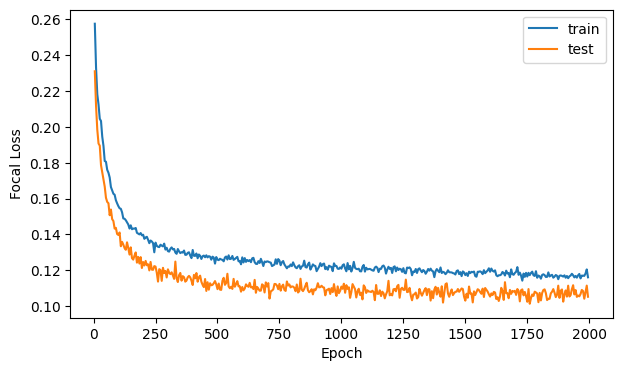

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
loss_type = 'Focal Loss' if base.use_focal_loss else 'BCE Loss'
ax.set_ylabel(loss_type)
# fig.show()

# Evaluation

## Predictions performances

In [84]:
pn.Row(base.param.data_set)

BokehModel(combine_events=True, render_bundle={'docs_json': {'62ccae3e-7972-4831-8ea1-9b61dcc4a542': {'version…

In [85]:
dataset_choice = {
    'train': {
        'data': {
            'x': train_test_data.tensors['X_train']['all'],
            'y': train_test_data.tensors['y_train'],
        },
        'already_processed': True,
    },
    'validation': {
        'data': {
            'x': train_test_data.tensors['X_test']['all'],
            'y': train_test_data.tensors['y_test'],
        },
        'already_processed': True,
    },
    'train + validation': {
        'data': df_heart_train,
        'already_processed': False,
    },
    'test': {
        'data': df_heart_test,
        'already_processed': False,
    },
    'all': {
        'data': df_heart,
        'already_processed': False,
    },
}
print('We are displaying evaluation over the {} dataset'.format(base.data_set.upper()))
data_specs = dataset_choice[base.data_set]

We are displaying evaluation over the TEST dataset


In [86]:
if data_specs['already_processed']:
    print('Data were already processed for training.')
    x_features = data_specs['data']['x'] # A dictionary
    y_true = data_specs['data']['y']
else:
        print('Processing data')
        processed_data, _, _, _ = lib.pre_process_features(
                data_specs['data'],
                num_features=num_features,
                categorical_features=categorical_features,
                category_to_drop=None,
                label_col=label_col,
                add_one_hot_encoded=base.add_one_hot_encoded,
                add_embeddings=base.add_embeddings,
                stand_features=base.stand_features,
        				stand_embeddings=base.stand_embeddings,
                test_size=base.test_size,
                random_state=base.random_state_test_train_split,
                split_data=False,
								replace_pb_values={
										'Cholesterol': {
												'target_to_replace': 0,
												'replacement_method': 'median',
										}
								},
        )
        x_features = processed_data.tensors['X_train'] # Now importing a dictionary
        y_true = processed_data.tensors['y_train']

Processing data
Before: Number of rows with problematic value: (31,)
After: Number of rows with problematic value: (0,)
adding One Hot Encoded
['M' 'F']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


In [87]:
model.eval()
y_pred_tensor = torch.squeeze(model(x_features['all']))
y_pred_round_tensor = y_pred_tensor.round()
y_pred = y_pred_tensor.detach().numpy()
y_pred_round = y_pred_round_tensor.detach().numpy()

torch.Size([184, 20])
tensor([[0.6809, 0.4907, 0.3618,  ..., 0.0000, 1.0000, 0.0000],
        [0.6170, 0.6296, 0.2684,  ..., 0.0000, 1.0000, 0.0000],
        [0.7234, 0.5370, 0.2863,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.2128, 0.4259, 0.1491,  ..., 0.0000, 0.0000, 1.0000],
        [0.4255, 0.3519, 0.3101,  ..., 0.0000, 0.0000, 1.0000],
        [0.5532, 0.4444, 0.2763,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([184, 50])
tensor([[0.3635, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5385],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2322, 0.0000, 0.0137,  ..., 0.1905, 0.0000, 0.1925],
        [0.0000, 0.0000, 0.0000,  ..., 0.2035, 0.0000, 0.2923],
        [0.2399, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7835]],
       grad_fn=<ReluBackward0>)


In [88]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [89]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,83.2%,82.1%,86.1%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

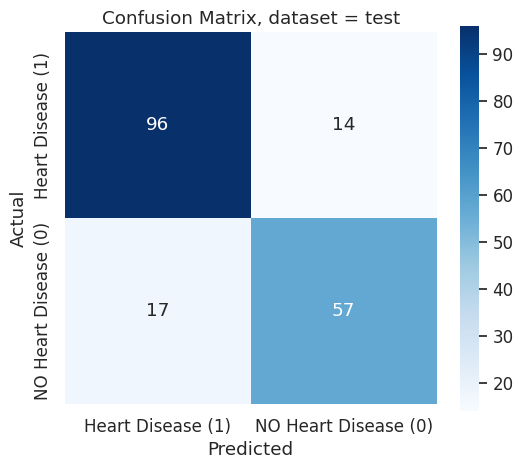

In [90]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [91]:
logreg_conf_matrix

array([[57, 17],
       [14, 96]])

In [92]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/heart/graph.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/heart/graph.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


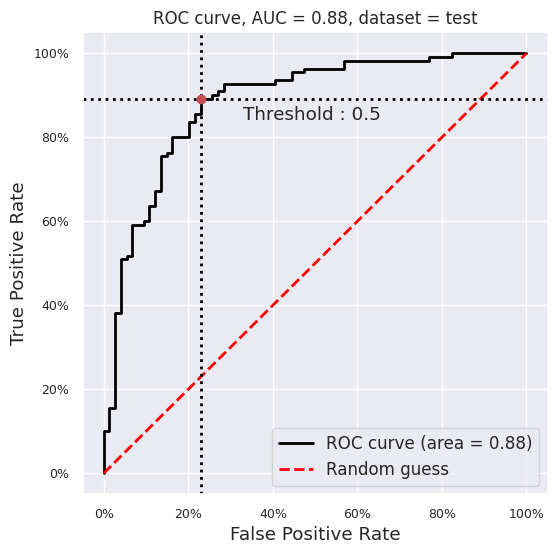

In [93]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

# Shap

In [ ]:
pn.Row(base.param.data_set)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a6c2171d-4161-4424-807e-f7323f8e7177': {'version…

In [281]:

train_test_data, final_categorical_features, all_features, embeddings_output = lib.pre_process_features(
        df_heart_train,
        num_features=num_features,
        categorical_features=categorical_features,
        category_to_drop=None,
        label_col=label_col,
        add_embeddings=base.add_embeddings,
        add_one_hot_encoded=base.add_one_hot_encoded,
        stand_features=base.stand_features,
        stand_embeddings=base.stand_embeddings,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
)
X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
X_train_df = train_test_data.dataframes['X_train']

adding embeddings


In [276]:
import shap

In [277]:
# X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
# y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
# X_train_df = train_test_data.dataframes['X_train']
X_test.keys()

dict_keys(['num', 'cat', 'all'])

In [284]:
X_train['num'][0:1]

tensor([[0.4375, 0.7000, 0.4367, 0.5926, 0.8537]])

In [298]:
# compute the SHAP values for the linear model
# explainer = shap.Explainer(model)
explainer = shap.DeepExplainer(
    model,
		[X_train['num'], X_train['cat']],
    # link=shap.links.logit,
		# algorithm='auto',
    )

In [304]:
import shap

In [306]:
shap_values = explainer.shap_values([X_train['num'][:2], X_train['cat'][:2]])

RuntimeError: only Tensors of floating point dtype can require gradients

In [309]:
# requires_grad=True
lala = X_train['cat'][:2]
type(lala)


torch.Tensor

In [310]:
lala.requires_grad

False

# Appendix

In [43]:
model_2 = torch.nn.Sequential(
    torch.nn.Linear(3, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 1),
)

print(model_2(torch.randn(4, 3))) # feed it 4 random 3-dim. vectors

tensor([[0.3709],
        [0.4930],
        [0.4063],
        [0.3934]], grad_fn=<AddmmBackward0>)


In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        print('be loss is {}'.format(be_loss))
        print('pt is {}'.format(pt))
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

In [ ]:
# From https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x


class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
class LogisticRegression(torch.nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         

     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs
     

     def compute_loss(self, y_pred, y_true):
         return F.binary_cross_entropy(y_pred, y_true)


     def compute_l1_loss(self, w):
         return torch.abs(w).sum()


def add_l1_loss( model, loss, lambda_lasso: float = 0.01):
    # TODO(pinolej): Check whether can be added to the class
    l1_parameters = []
    for parameter in model.parameters():
        l1_parameters.append(parameter.view(-1))
    l1 = lambda_lasso * model.compute_l1_loss(torch.cat(l1_parameters))
    # Add L1 loss component
    loss += l1
    return loss

In [ ]:
# Inspired from https://towardsdatascience.com/the-secret-to-improved-nlp-an-in-depth-look-at-the-nn-embedding-layer-in-pytorch-6e901e193e16

# Define the embedding layer with 10 vocab size and 50 vector embeddings.
embedding = torch.nn.Embedding(10, 50)

embedding(torch.LongTensor([2]))

# Load a pre-trained embedding model
pretrained_embeddings = torch.randn(10, 50) # Example only, not actual pre-trained embeddings

# Initialize the embedding layer with the pre-trained embeddings
embedding.weight.data.copy_(pretrained_embeddings)